# Temporal recalibration project

kcho, Friday, September 22, 2017

## Import libraries

In [471]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from peakutils.peak import indexes
import scipy.interpolate as interpolate
from scipy.signal import butter, lfilter, freqz, find_peaks_cwt
import peakutils


%matplotlib inline

> Data from DH

In [12]:
ls

README.md                   park_5_exp_1_dataLog.txt
Untitled.ipynb              park_5_exp_2_dataLog.txt
park_3_2_exp_0_dataLog.txt  park_5_exp_3_dataLog.txt
park_3_2_exp_1_dataLog.txt  park_5_exp_4_dataLog.txt
park_5_exp_0_dataLog.txt


## 1. Load data

In [13]:
data = pd.read_csv('park_3_2_exp_1_dataLog.txt', sep=',')

> How the raw data looks

In [14]:
data.head()

time[us]  volt(fsr)[v]  signal  signal frequency[Hz]
0  221869028             0       0                  1000
1  221869389             0       0                  1000
2  221869750             0       0                  1000
3  221870110             0       0                  1000
4  221870470             0       0                  1000

## 2. Data observation

> Data shape

In [15]:
data.shape

(217711, 4)

> `time[us]` column

In [16]:
data['time[us]'].head()

0    221869028
1    221869389
2    221869750
3    221870110
4    221870470
Name: time[us], dtype: int64

- Range of the time

In [17]:
print('starts from : {}\nends at : {}'.format(
    data['time[us]'].min(), 
    data['time[us]'].max()))

starts from : 221869028
ends at : 300492272


- Increasement in the time axis

    - eg) t2 - t1

In [18]:
np.ediff1d(data['time[us]'])

array([361, 361, 360, ..., 360, 361, 361])

- Unique values of the time increasement

In [19]:
np.unique(np.ediff1d(data['time[us]']))

array([ 358,  359,  360,  361,  362,  363,  364,  365,  366,  367,  368,
        369,  370,  371, 1060, 1061])

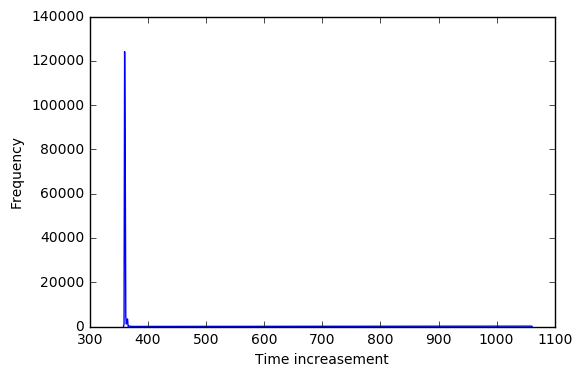

In [42]:
tmp = pd.DataFrame(np.ediff1d(data['time[us]']))
tmp.columns = ['time increasement']
tmp = tmp.reset_index() 
plt.plot(tmp.groupby('time increasement').count().index, tmp.groupby('time increasement').count()['index'])
plt.ylabel('Frequency')
plt.xlabel('Time increasement')

In [629]:
tmp.groupby('time increasement').count().T

time increasement  358   359     360    361   362   363   364   365   366   \
index                 4  1025  124161  79961  4341  1134  2741  3423   104   

time increasement  367   368   369   370   371   1060  1061  
index               184   188    96   150    23   155    20

In [33]:
tmp.groupby('time increasement').count().index

Int64Index([ 358,  359,  360,  361,  362,  363,  364,  365,  366,  367,  368,
             369,  370,  371, 1060, 1061],
           dtype='int64', name='time increasement')

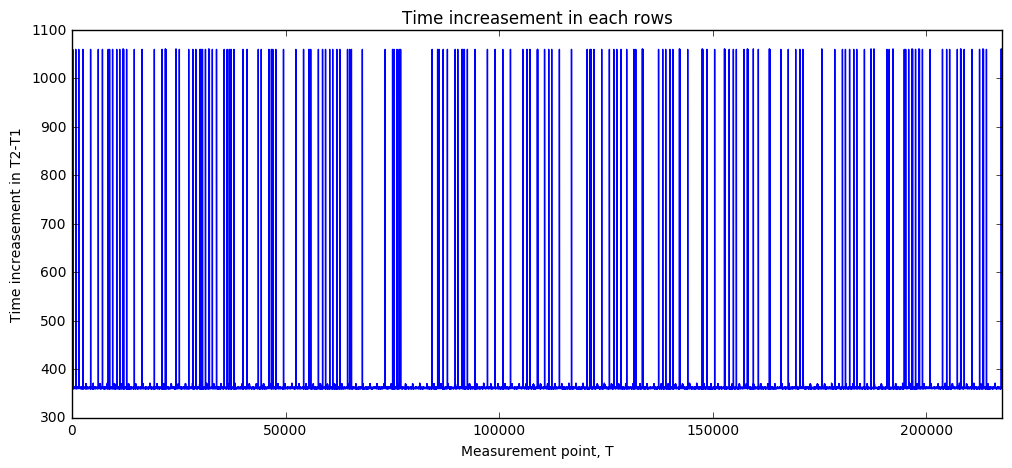

In [50]:
plt.figure(figsize=(12,5))
plt.plot(np.ediff1d(data['time[us]']))
plt.title('Time increasement in each rows')
plt.xlim(0, len(tmp))
plt.xlabel('Measurement point, T')
plt.ylabel('Time increasement in T2-T1')
plt.show()

- Above shows that the time column is sparse

## 3. Interpolation

In [631]:
f = interpolate.interp1d(data['time[us]'], data['volt(fsr)[v]'])
gap = 360
y = f(np.arange(data['time[us]'].min(), data['time[us]'].max(), gap))

f_signal = interpolate.interp1d(data['time[us]'], data['signal'], kind='nearest')
y_signal = f_signal(np.arange(data['time[us]'].min(), data['time[us]'].max(), gap))

> Data size before the interpolation

In [632]:
len(data)

217711

> Data size after the interpolation

In [633]:
len(y)

218398

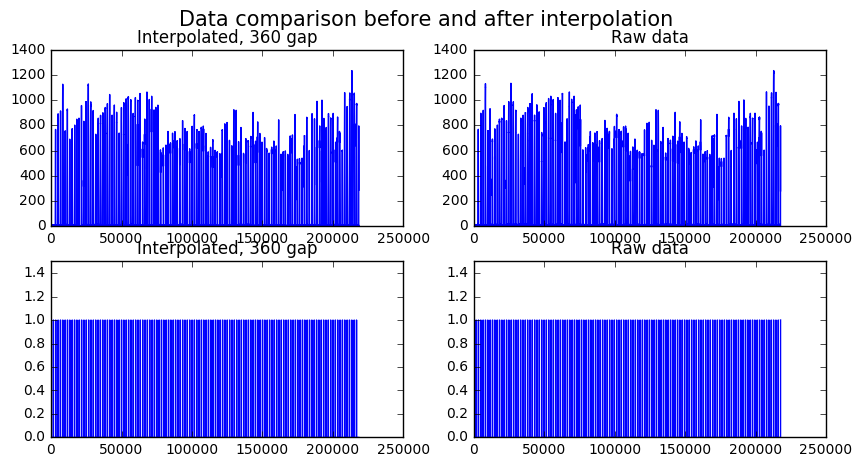

In [637]:
fig, ax = plt.subplots(ncols=2, nrows=2, figsize=(10,5))
ax = np.ravel(ax)
ax[0].plot(y)
ax[0].set_title('Interpolated, 360 gap')
ax[1].plot(data['volt(fsr)[v]'])
ax[1].set_title('Raw data')

ax[2].plot(y_signal)
ax[2].set_title('Interpolated, 360 gap')
ax[2].set_ylim(0,1.5)
ax[3].plot(data['signal'])
ax[3].set_title('Raw data')
ax[3].set_ylim(0,1.5)

plt.suptitle('Data comparison before and after interpolation', fontsize=15)
plt.show()

> Save the interpolated as `data_reponse_interp_360`

In [227]:
data_reponse_interp_360 = pd.DataFrame({'time[us]':np.arange(data['time[us]'].min(), data['time[us]'].max(), gap),
                                        'volt(fsr)[v]':y,
                                        'signal':y_signal})

## 4. Smoothing

In [758]:
b, a = signal.butter(5, 0.06)
# b, a = signal.butter(3, 0.02)
data_reponse_interp_360['svolt(fsr)[v]'] = signal.filtfilt(b, a, data_reponse_interp_360['volt(fsr)[v]'])

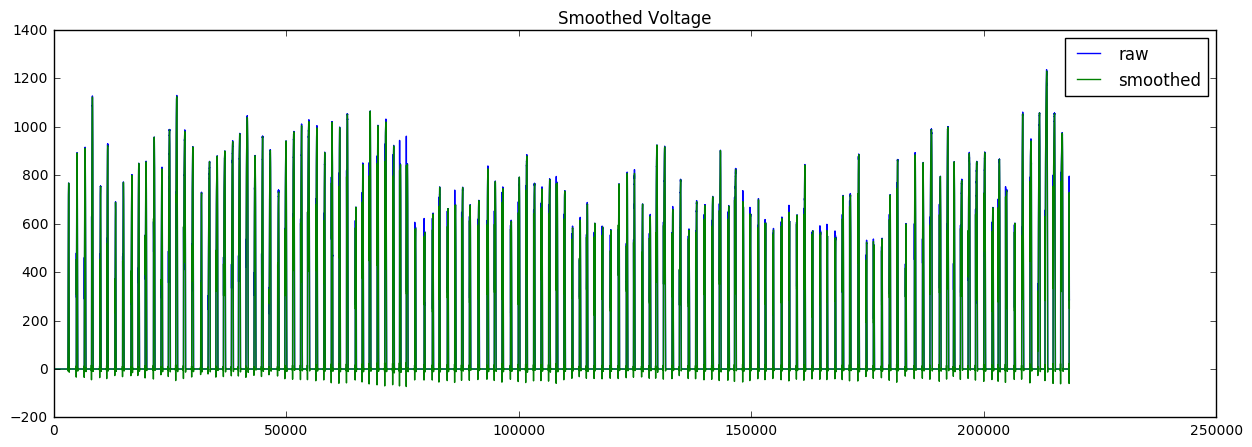

In [759]:
fig = plt.figure(figsize=(15,5))
plt.plot(data_reponse_interp_360['volt(fsr)[v]'], label='raw')
plt.plot(data_reponse_interp_360['svolt(fsr)[v]'], label='smoothed')
plt.title('Smoothed Voltage')
plt.legend()
plt.show()

## 5. Threshold the response

In [760]:
threshold = 80
data_reponse_interp_360.loc[data_reponse_interp_360['svolt(fsr)[v]'] < 80, 'svolt(fsr)[v]'] = 0 

## 6. Estimate gradient of the response

In [761]:
data_reponse_interp_360['gradient'] = np.gradient(data_reponse_interp_360['svolt(fsr)[v]'])

## 7. Split the dataframe

In [762]:
# difference between consecutive element
pre_post_signal_diff = np.ediff1d(data_reponse_interp_360['signal'])

# where the difference is +1 : Signal turning on (0 --> 1)
# 1 has been added to return the index of first 'on'
signal_first_ones_index = np.where(pre_post_signal_diff==1)[0] + 1
signal_first_ones_time = data_reponse_interp_360.loc[signal_first_ones_index, 'time[us]'].values

signal_last_ones_index = np.where(pre_post_signal_diff==-1)[0]
signal_last_ones_time = data_reponse_interp_360.loc[signal_last_ones_index, 'time[us]'].values

# 300 ms
# need to make this multiples of 360
cut_window_div = 300000 / 360
cut_time = signal_first_ones_index - round(cut_window_div)

data_split = np.split(data_reponse_interp_360, 
                      cut_time)

## 8. Find peaks in each epochs

In [765]:
pd.DataFrame([onset_time, first_peak_time, dip_time, second_peak_time, offset_time]).T


0          1          2          3          4
0  299232668  299240228  299248868  299345348  299400428

Error in detecting peaks


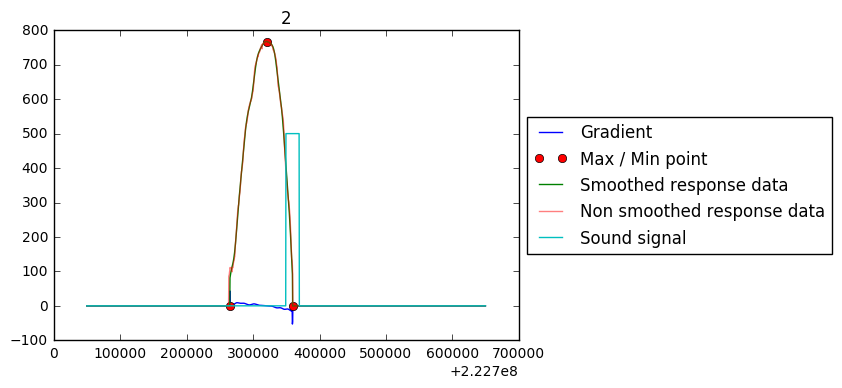

   onset_time  first_peak_time   dip_time  second_peak_time  offset_time
0   223608908        223616108  223623308         223665788    223717628


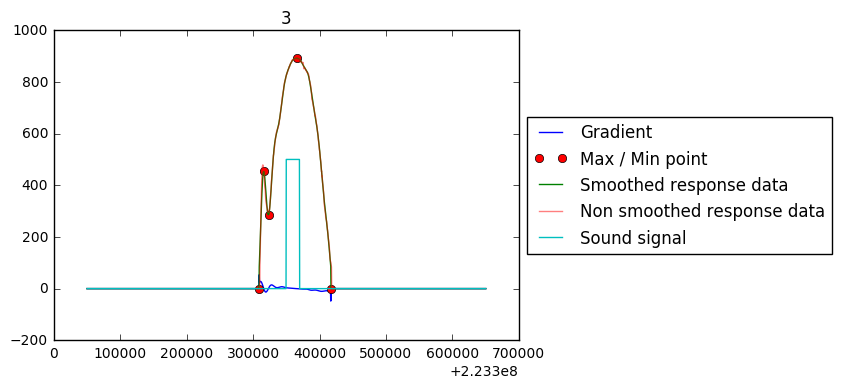

   onset_time  first_peak_time   dip_time  second_peak_time  offset_time
0   224227028        224234228  224241068         224293628    224352308


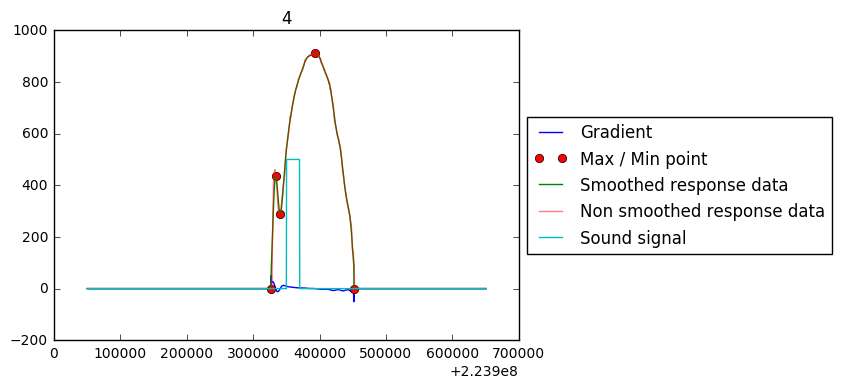

   onset_time  first_peak_time   dip_time  second_peak_time  offset_time
0   224789708        224797268  224803388         224857748    224912468


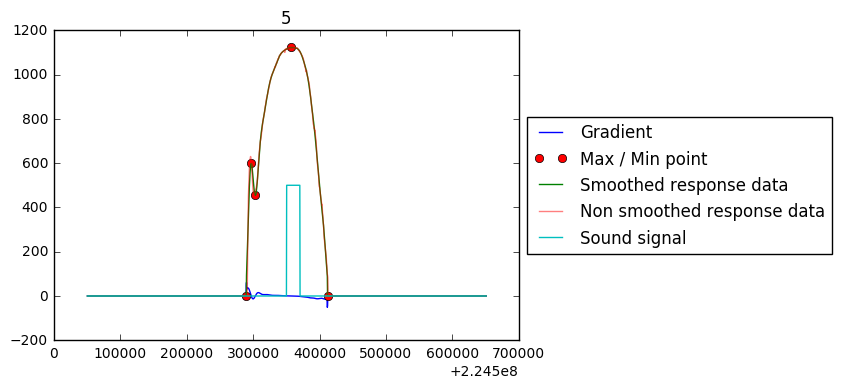

   onset_time  first_peak_time   dip_time  second_peak_time  offset_time
0   225425828        225433028  225440948         225487388    225526268


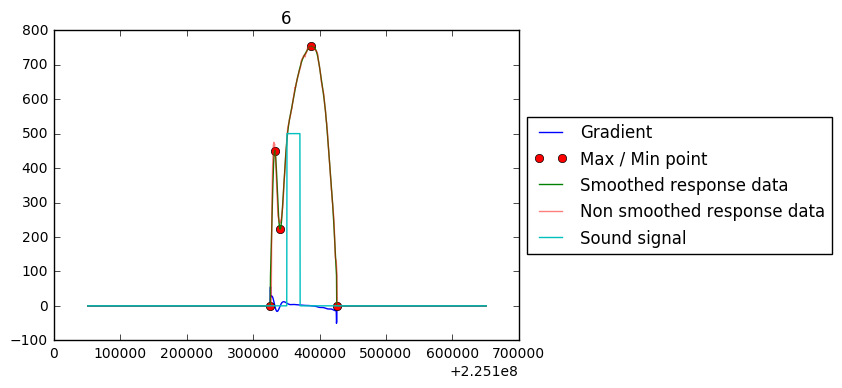

   onset_time  first_peak_time   dip_time  second_peak_time  offset_time
0   225968348        225975548  225983468         226038188    226081388


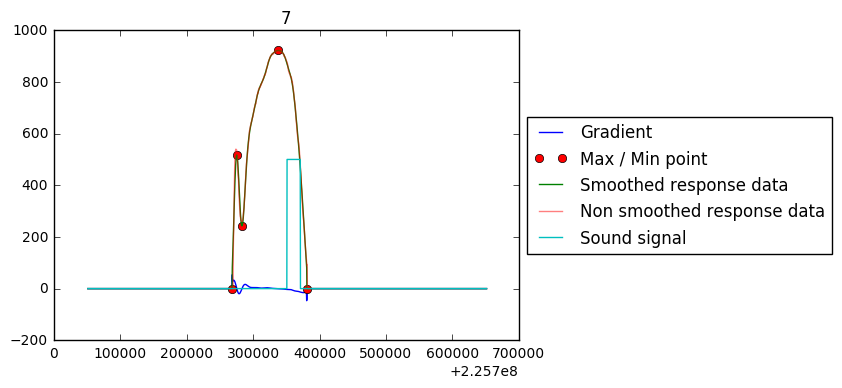

   onset_time  first_peak_time   dip_time  second_peak_time  offset_time
0   227192708        227199908  227207828         227256788    227311148


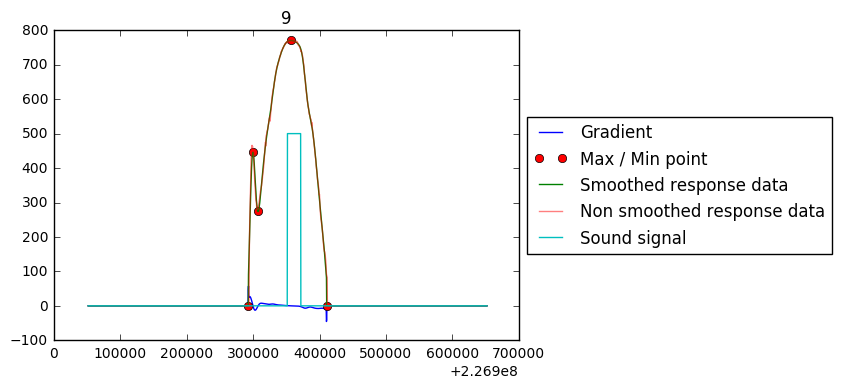

   onset_time  first_peak_time   dip_time  second_peak_time  offset_time
0   227838188        227845748  227854028         227915588    227956268


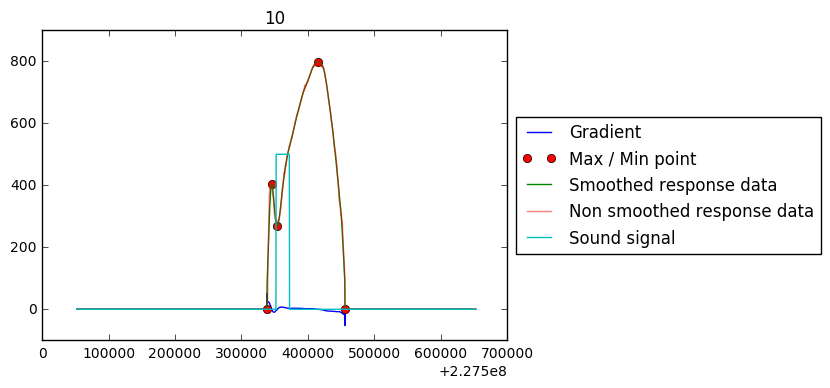

   onset_time  first_peak_time   dip_time  second_peak_time  offset_time
0   228375668        228383588  228390788         228444788    228496628


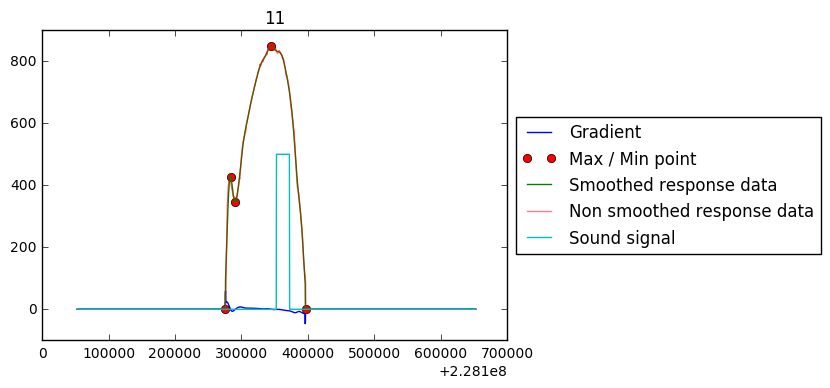

   onset_time  first_peak_time   dip_time  second_peak_time  offset_time
0   228939788        228947708  228955268         229011068    229057148


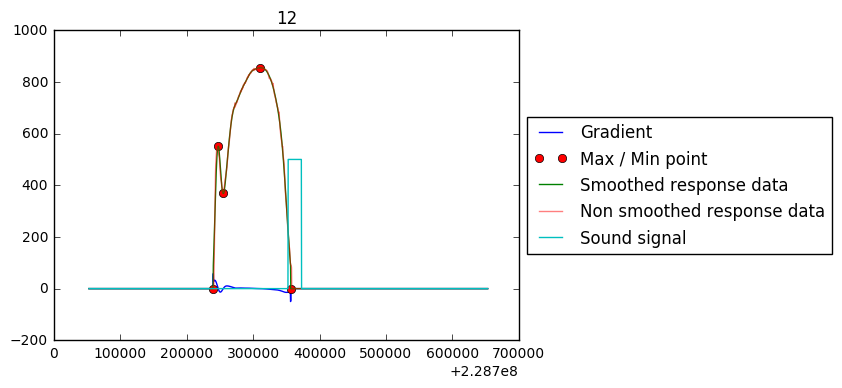

   onset_time  first_peak_time   dip_time  second_peak_time  offset_time
0   229582028        229590308  229597508         229645028    229700468


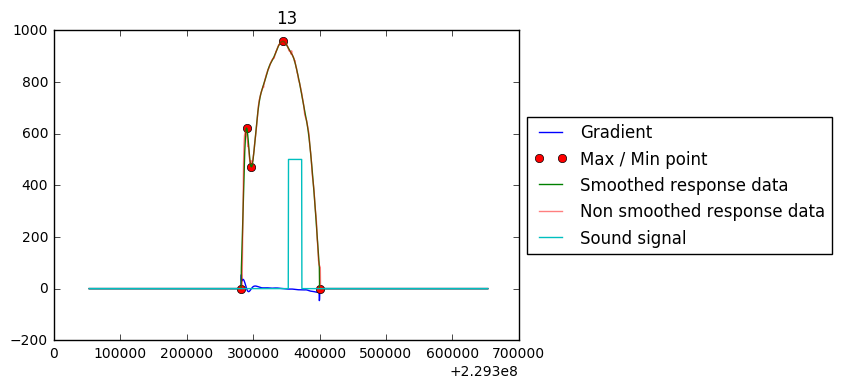

   onset_time  first_peak_time   dip_time  second_peak_time  offset_time
0   230164148        230171708  230179268         230244428    230289428


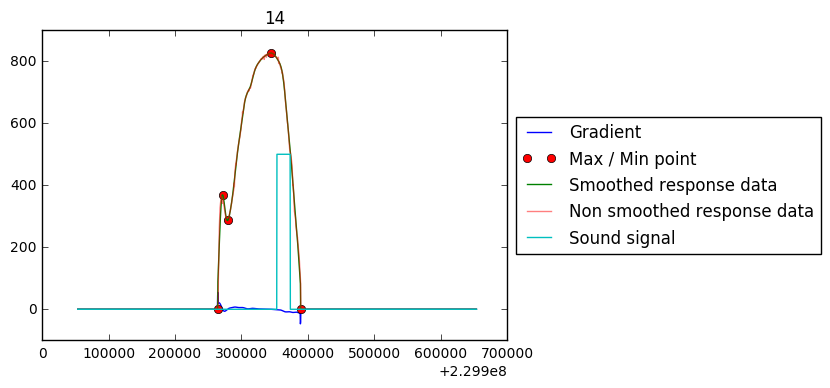

   onset_time  first_peak_time   dip_time  second_peak_time  offset_time
0   230737268        230744828  230752388         230828708    230883788


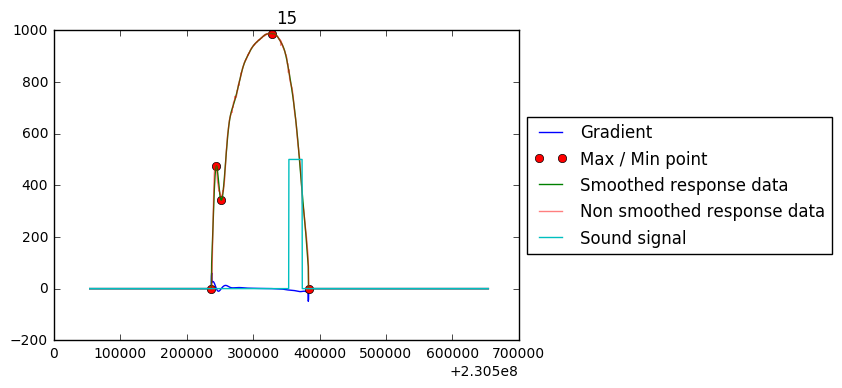

   onset_time  first_peak_time   dip_time  second_peak_time  offset_time
0   231308948        231317228  231324068         231388148    231452228


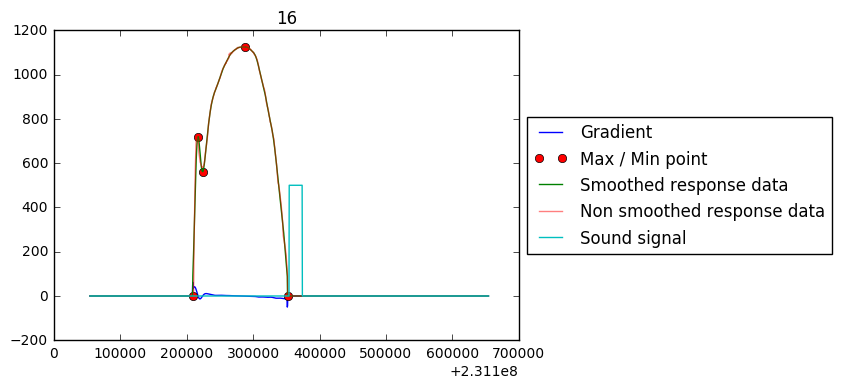

   onset_time  first_peak_time   dip_time  second_peak_time  offset_time
0   231908348        231916268  231924188         232008788    232066388


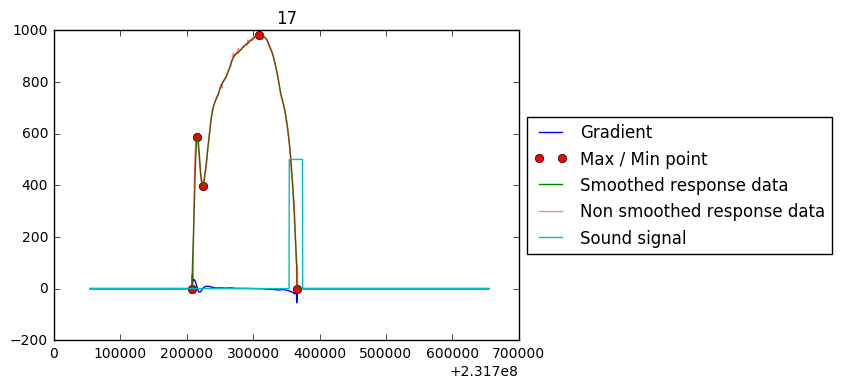

   onset_time  first_peak_time   dip_time  second_peak_time  offset_time
0   232545188        232552748  232560668         232632308    232679468


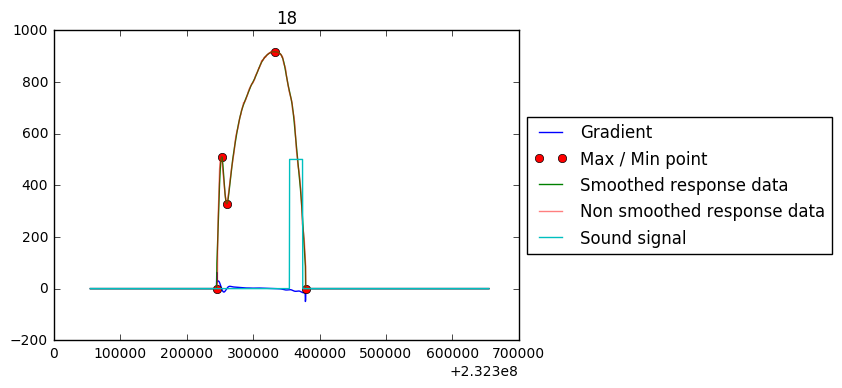

   onset_time  first_peak_time   dip_time  second_peak_time  offset_time
0   233238908        233246108  233252948         233301548    233340788


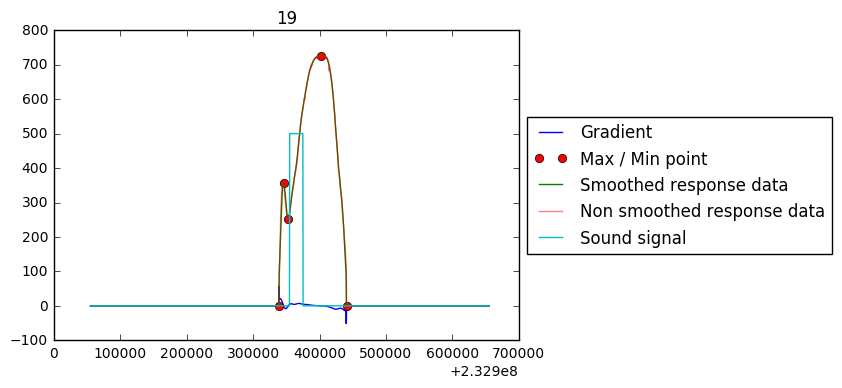

   onset_time  first_peak_time   dip_time  second_peak_time  offset_time
0   233814908        233822108  233827868         233925068    233980508


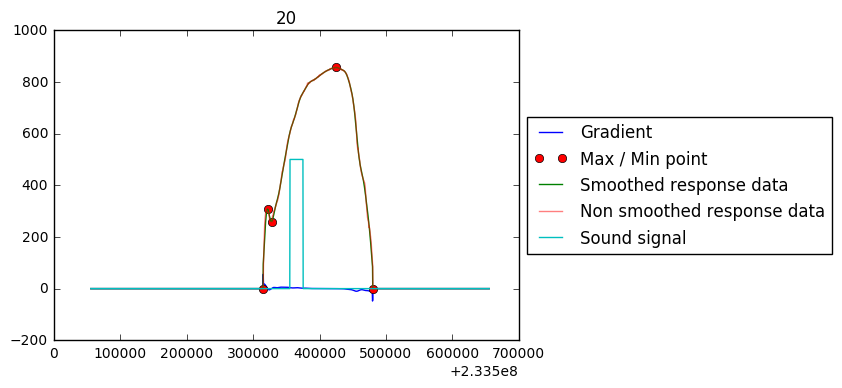

   onset_time  first_peak_time   dip_time  second_peak_time  offset_time
0   234416468        234424028  234431588         234517268    234570548


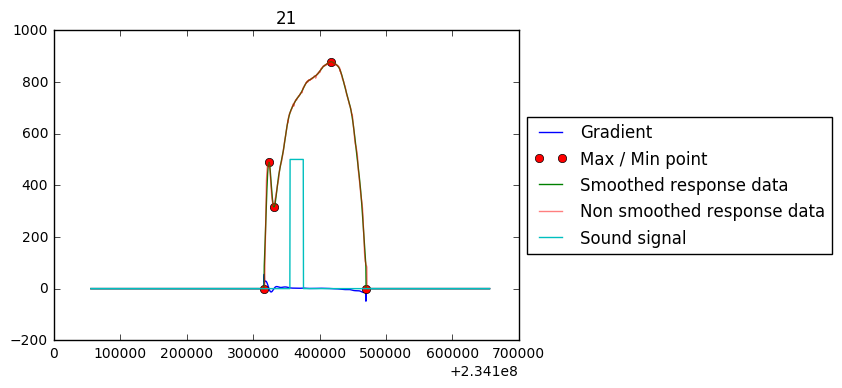

   onset_time  first_peak_time   dip_time  second_peak_time  offset_time
0   235001468        235008668  235015868         235110908    235161668


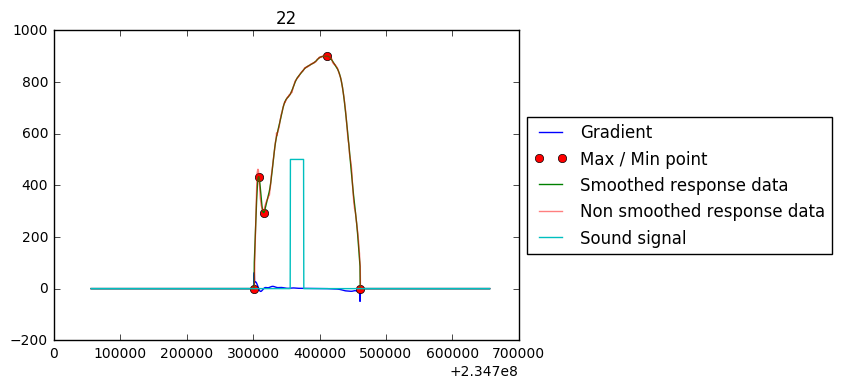

   onset_time  first_peak_time   dip_time  second_peak_time  offset_time
0   235617428        235624988  235631468         235718588    235769708


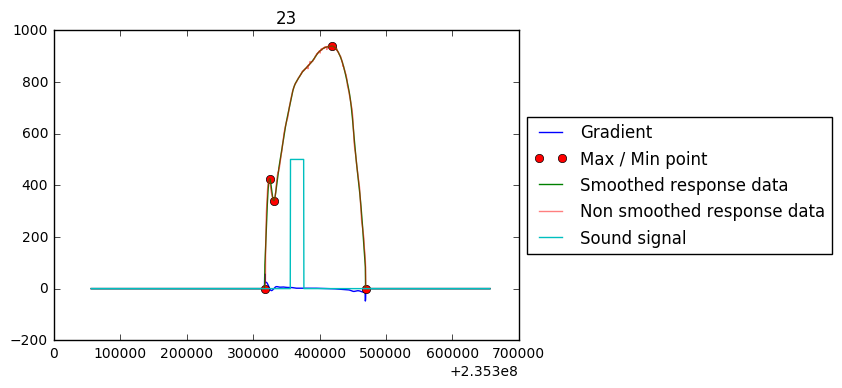

   onset_time  first_peak_time   dip_time  second_peak_time  offset_time
0   236161748        236169308  236176148         236262548    236317628


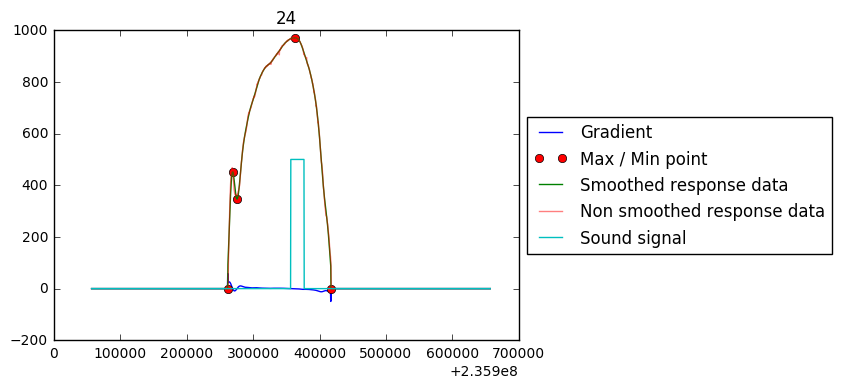

   onset_time  first_peak_time   dip_time  second_peak_time  offset_time
0   236742068        236750348  236757548         236846828    236917028


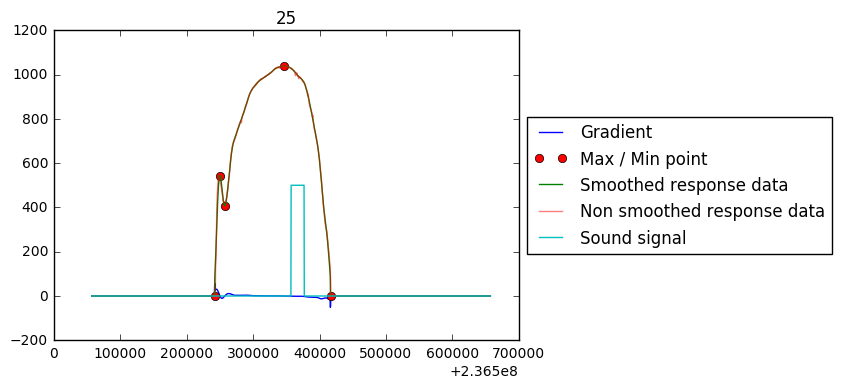

   onset_time  first_peak_time   dip_time  second_peak_time  offset_time
0   237366668        237374228  237380708         237455588    237511748


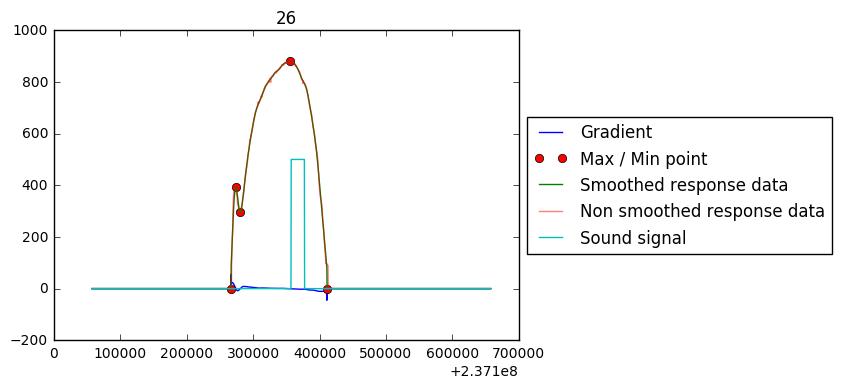

   onset_time  first_peak_time   dip_time  second_peak_time  offset_time
0   237950588        237958508  237965708         238034108    238085228


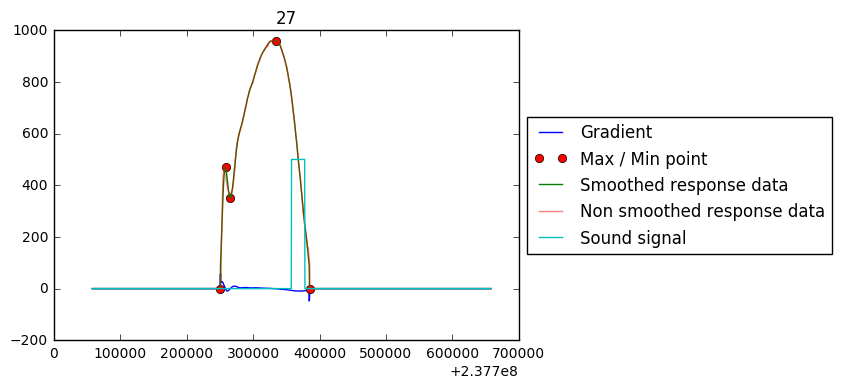

   onset_time  first_peak_time   dip_time  second_peak_time  offset_time
0   238530548        238537388  238544228         238632068    238684628


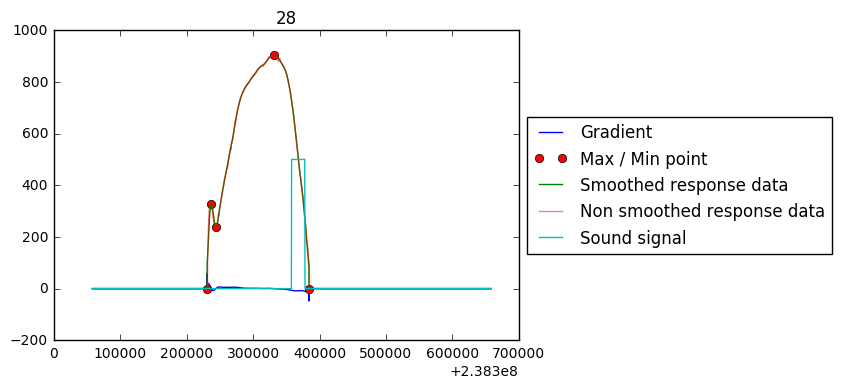

   onset_time  first_peak_time   dip_time  second_peak_time  offset_time
0   239194748        239202308  239210228         239268548    239318588


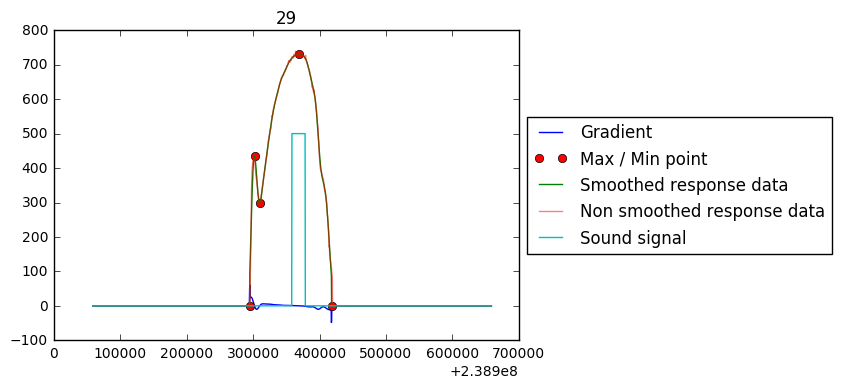

   onset_time  first_peak_time   dip_time  second_peak_time  offset_time
0   239755988        239763548  239771828         239848148    239903228


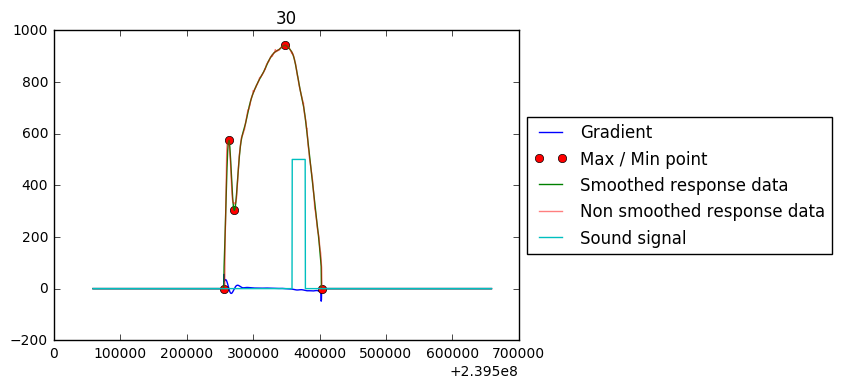

   onset_time  first_peak_time   dip_time  second_peak_time  offset_time
0   240358268        240366188  240374108         240449348    240504788


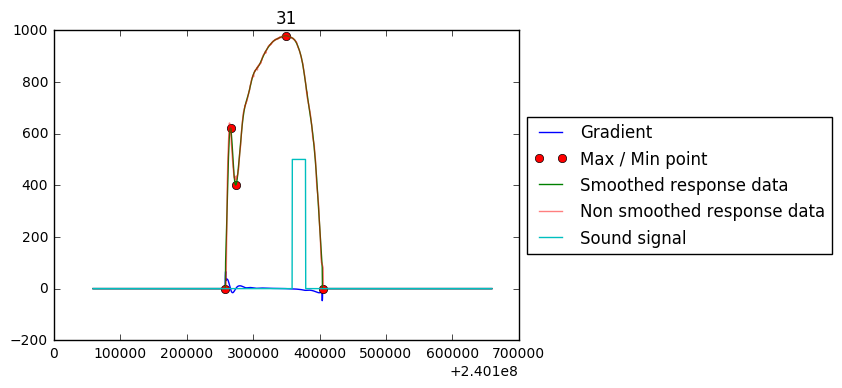

   onset_time  first_peak_time   dip_time  second_peak_time  offset_time
0   240968108        240975668  240983588         241051628    241105628


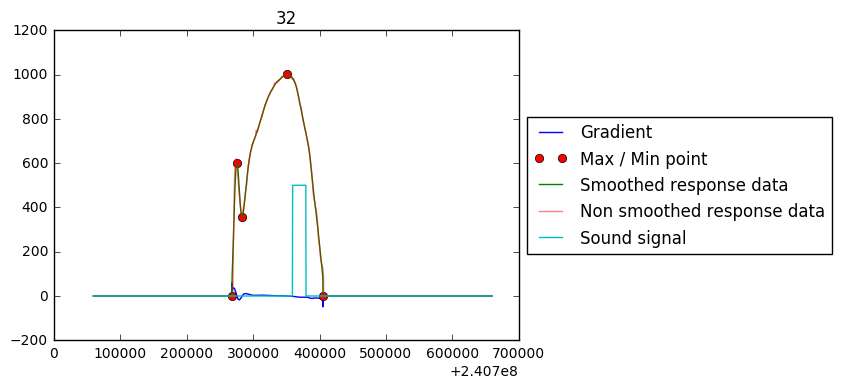

   onset_time  first_peak_time   dip_time  second_peak_time  offset_time
0   241510268        241518188  241526468         241612868    241672268


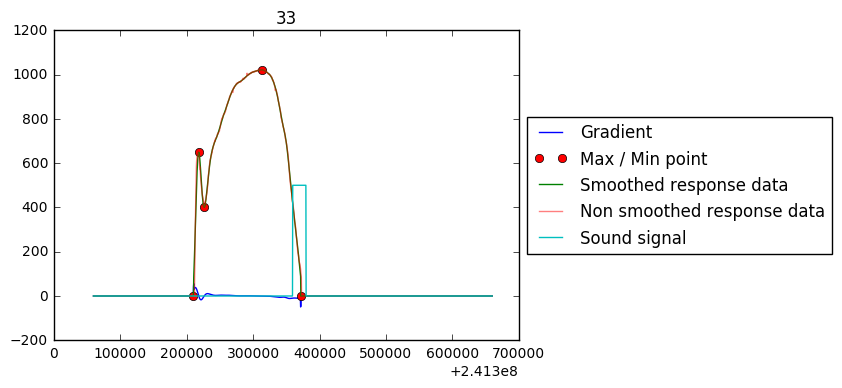

   onset_time  first_peak_time   dip_time  second_peak_time  offset_time
0   242155388        242163308  242171228         242235668    242285348


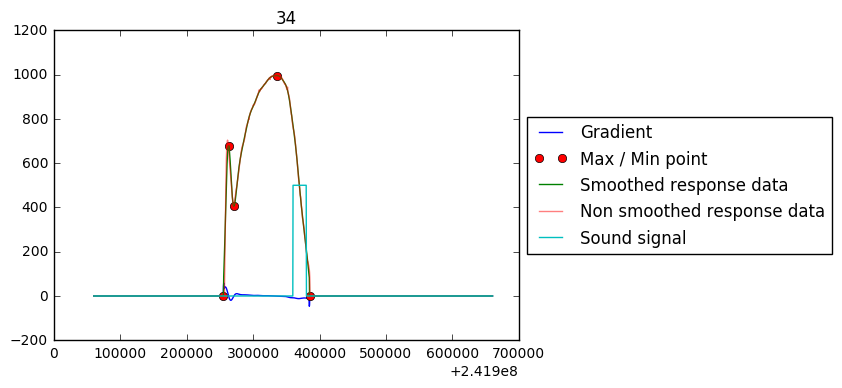

   onset_time  first_peak_time   dip_time  second_peak_time  offset_time
0   242771708        242779268  242787188         242843348    242881508


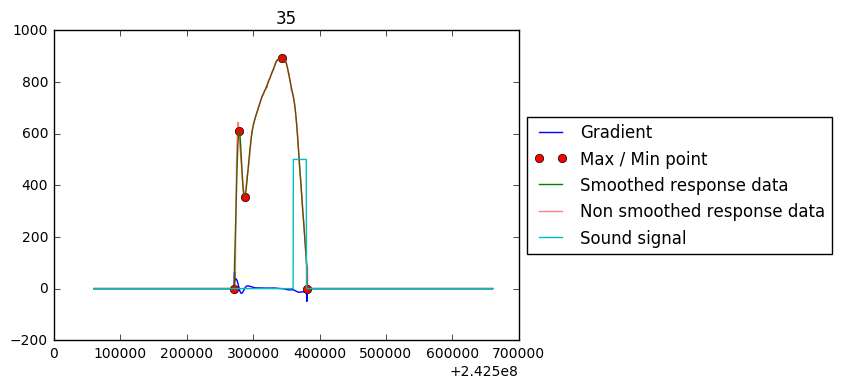

   onset_time  first_peak_time   dip_time  second_peak_time  offset_time
0   243352388        243360308  243367508         243411788    243471548


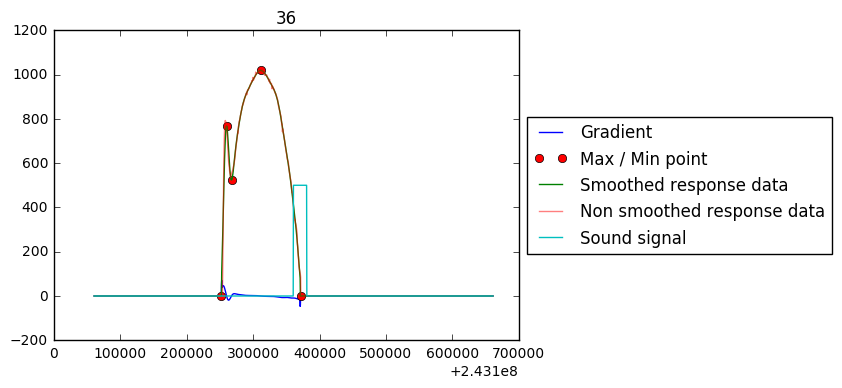

   onset_time  first_peak_time   dip_time  second_peak_time  offset_time
0   243942788        243950348  243958268         244001828    244054388


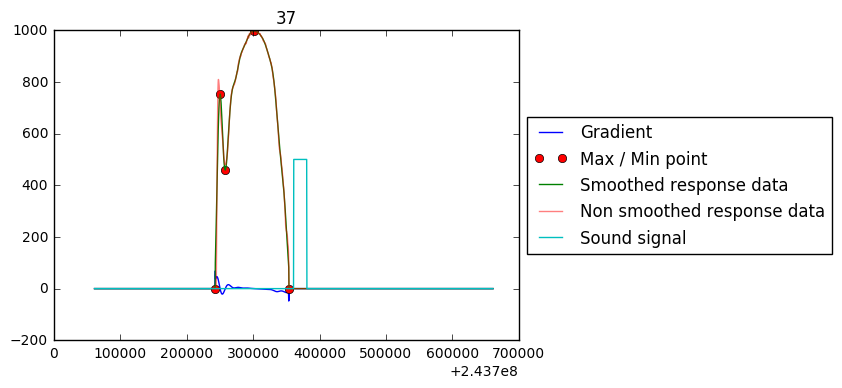

   onset_time  first_peak_time   dip_time  second_peak_time  offset_time
0   244529588        244537508  244544708         244595108    244654508


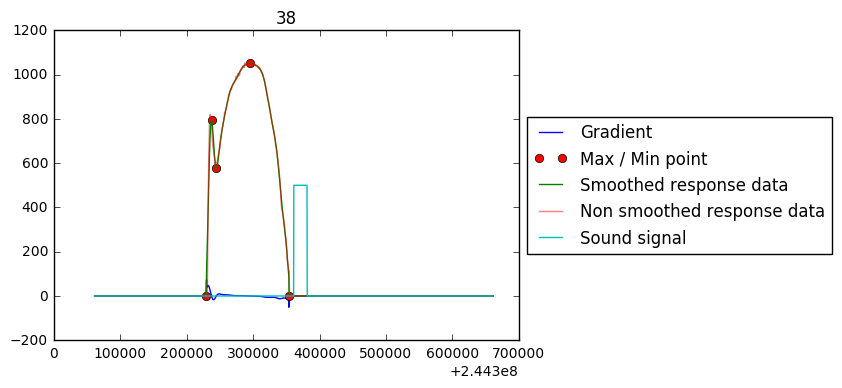

   onset_time  first_peak_time   dip_time  second_peak_time  offset_time
0   245734508        245742068  245750348         245793908    245842508


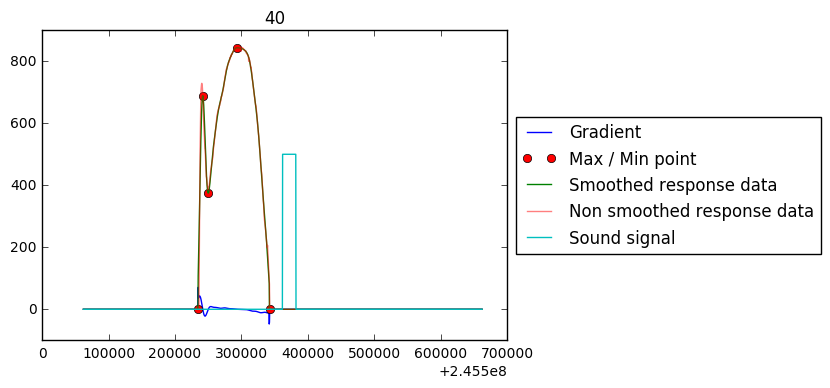

   onset_time  first_peak_time   dip_time  second_peak_time  offset_time
0   246283508        246291428  246299708         246366668    246413468


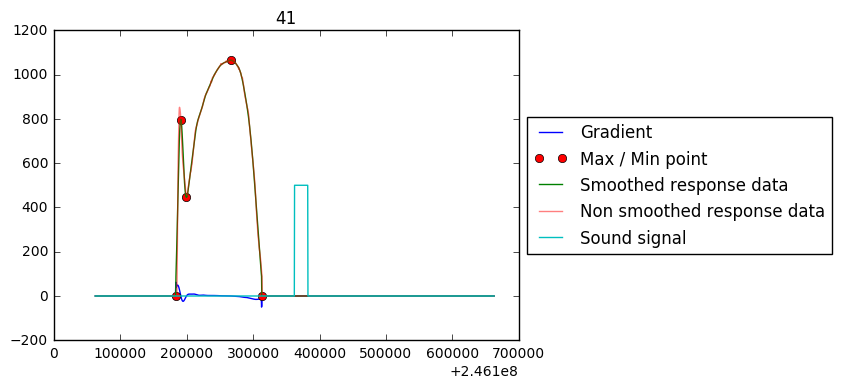

   onset_time  first_peak_time   dip_time  second_peak_time  offset_time
0   246896948        246904508  246913148         246964988    247009628


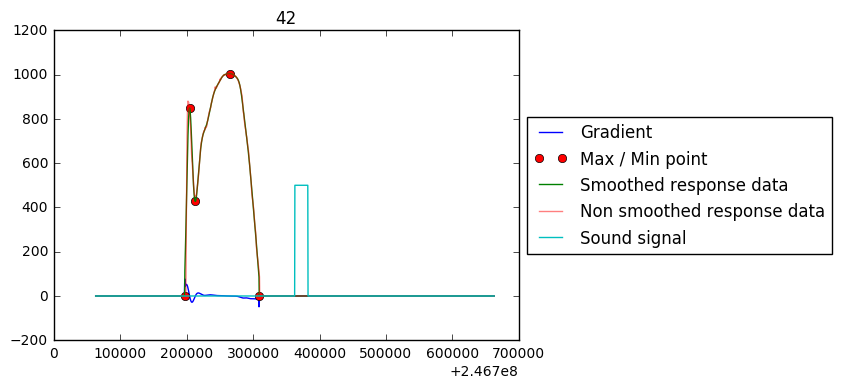

   onset_time  first_peak_time   dip_time  second_peak_time  offset_time
0   247491668        247499588  247508228         247575908    247628828


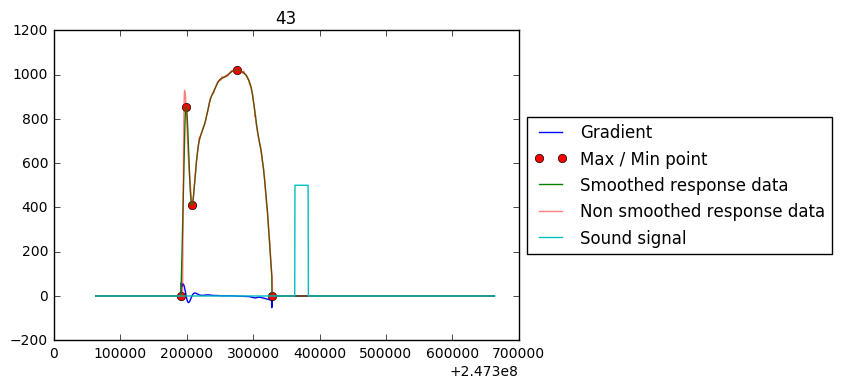

   onset_time  first_peak_time   dip_time  second_peak_time  offset_time
0   248105828        248113388  248122748         248185028    248227868


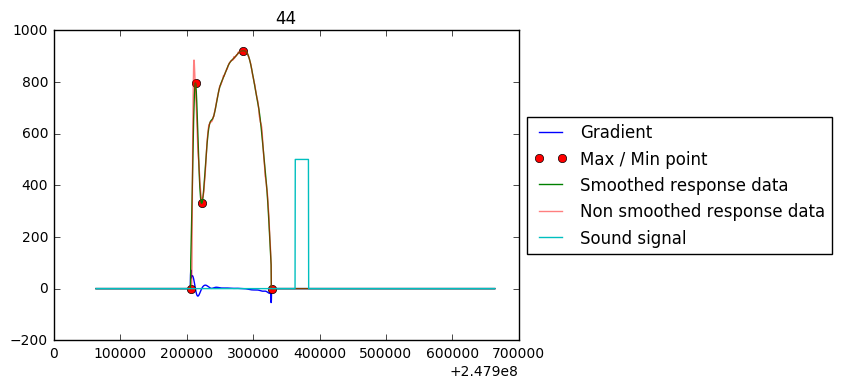

Error in detecting peaks


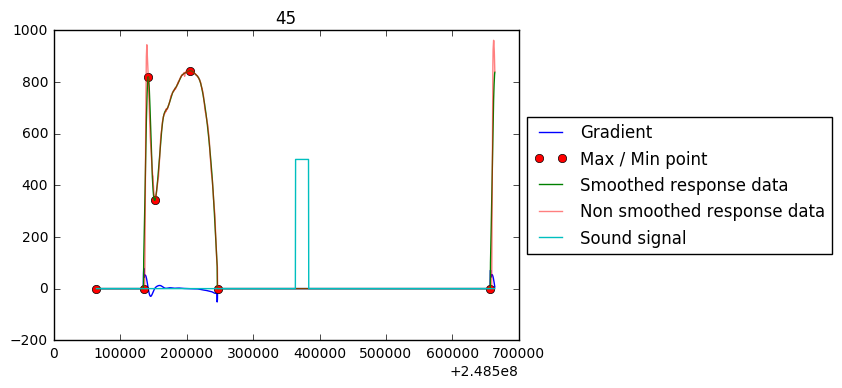

   onset_time  first_peak_time   dip_time  second_peak_time  offset_time
0   249164228        249164588  249174308         249243428    249288788


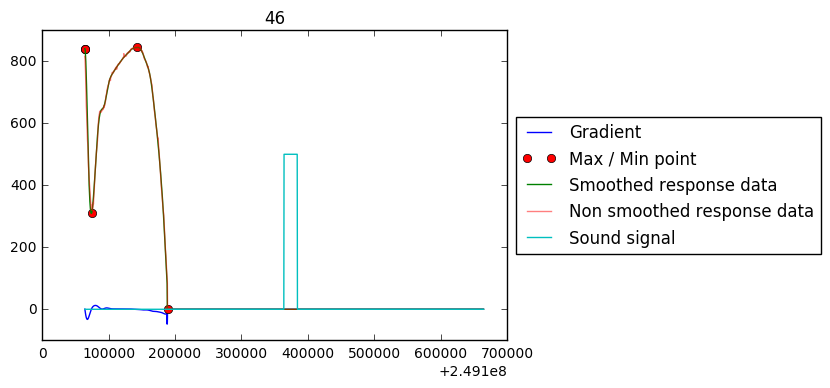

   onset_time  first_peak_time   dip_time  second_peak_time  offset_time
0   251685668        251692868  251702228         251743988    251785748


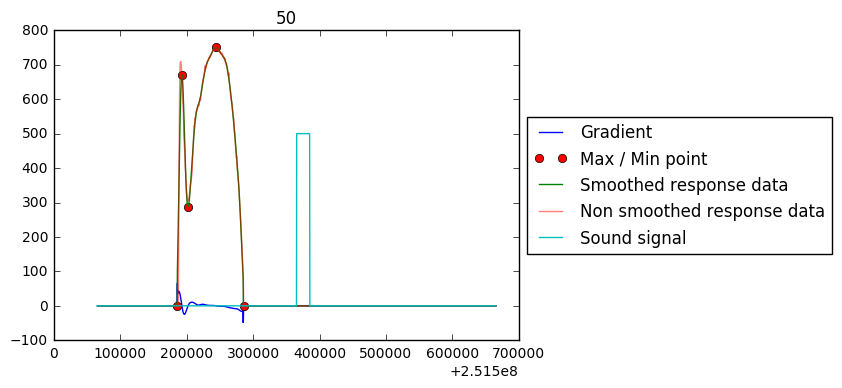

   onset_time  first_peak_time   dip_time  second_peak_time  offset_time
0   252903548        252910748  252920468         252966908    253011548


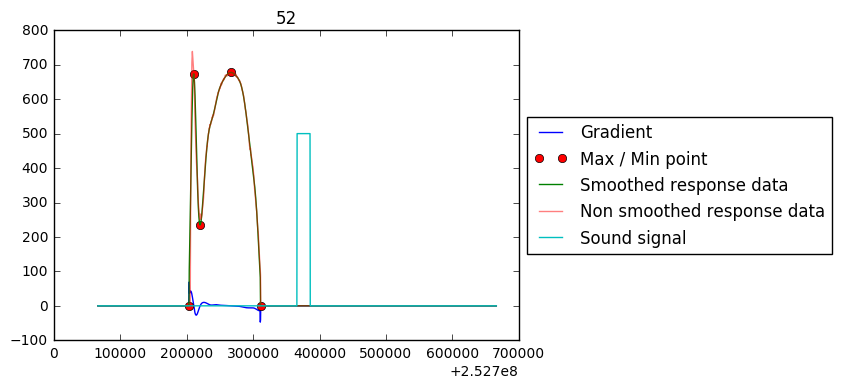

   onset_time  first_peak_time   dip_time  second_peak_time  offset_time
0   253438868        253446428  253455428         253521668    253561988


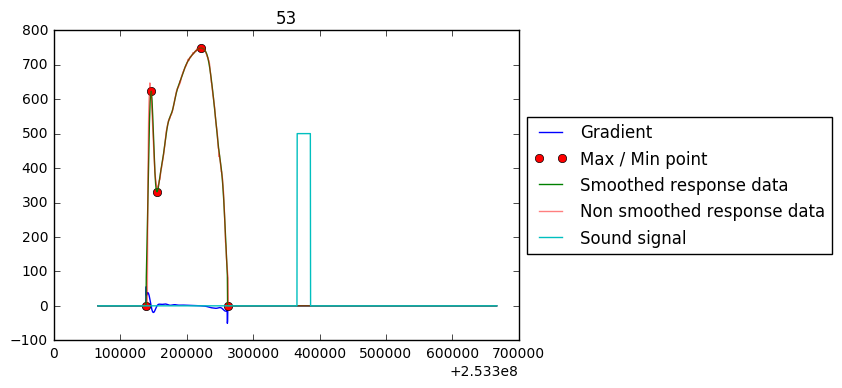

   onset_time  first_peak_time   dip_time  second_peak_time  offset_time
0   254041508        254048708  254058068         254101988    254145188


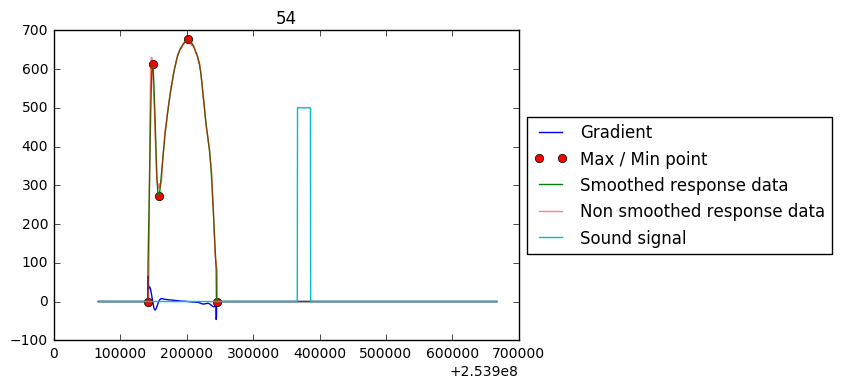

   onset_time  first_peak_time   dip_time  second_peak_time  offset_time
0   254700308        254707868  254717228         254773748    254812988


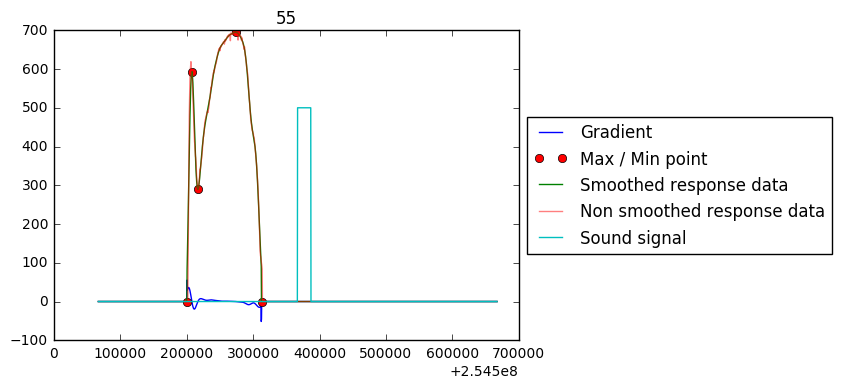

   onset_time  first_peak_time   dip_time  second_peak_time  offset_time
0   255401948        255409508  255418148         255475028    255523988


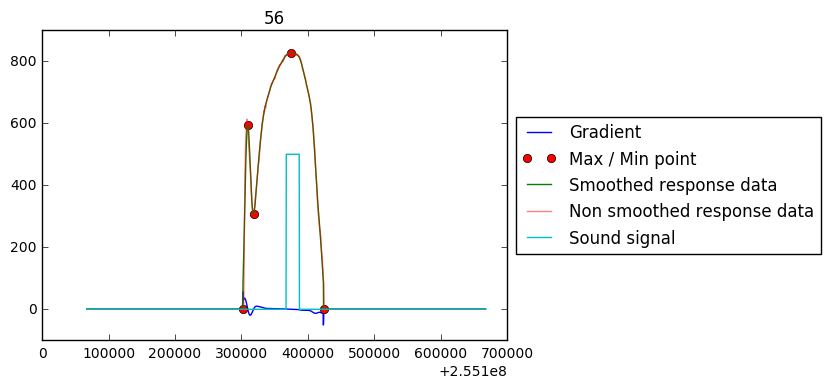

   onset_time  first_peak_time   dip_time  second_peak_time  offset_time
0   255971108        255978308  255987308         256050308    256105028


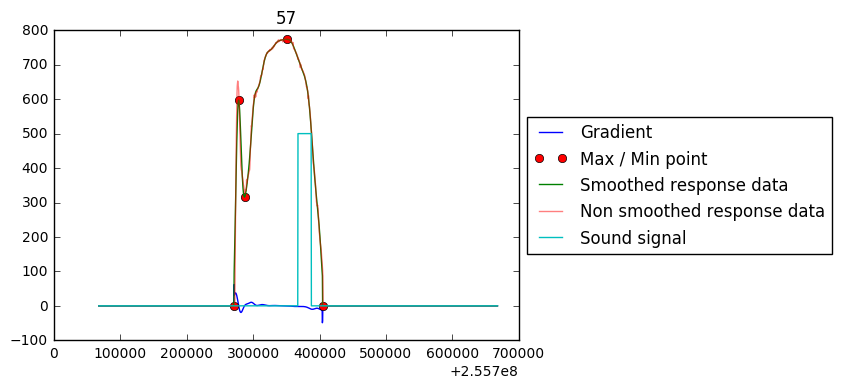

Error in detecting peaks


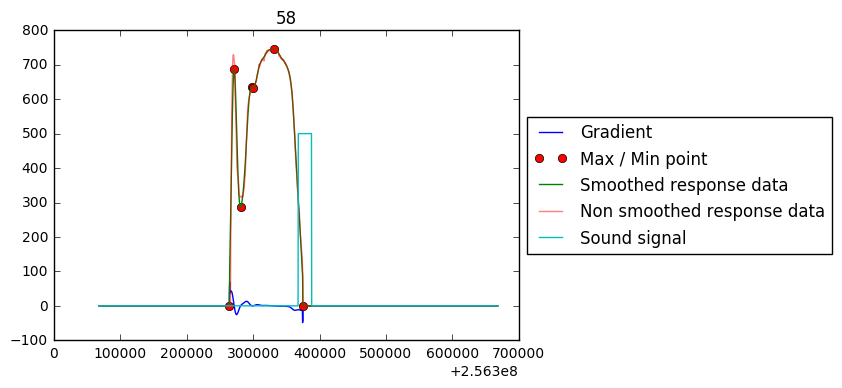

   onset_time  first_peak_time   dip_time  second_peak_time  offset_time
0   257222828        257230388  257239388         257284748    257326868


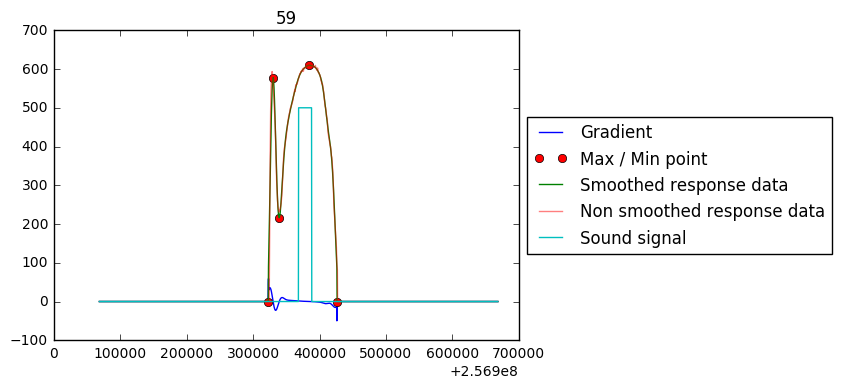

   onset_time  first_peak_time   dip_time  second_peak_time  offset_time
0   257823668        257830868  257840228         257909348    257956508


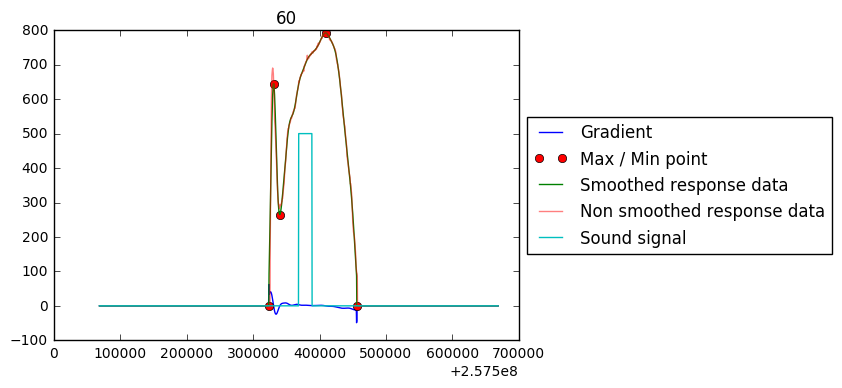

   onset_time  first_peak_time   dip_time  second_peak_time  offset_time
0   258406148        258413708  258422708         258488948    258532868


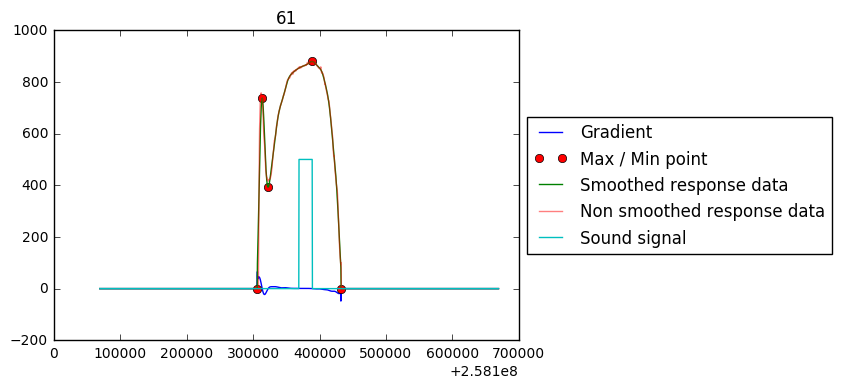

   onset_time  first_peak_time   dip_time  second_peak_time  offset_time
0   259012748        259020308  259028948         259087988    259130468


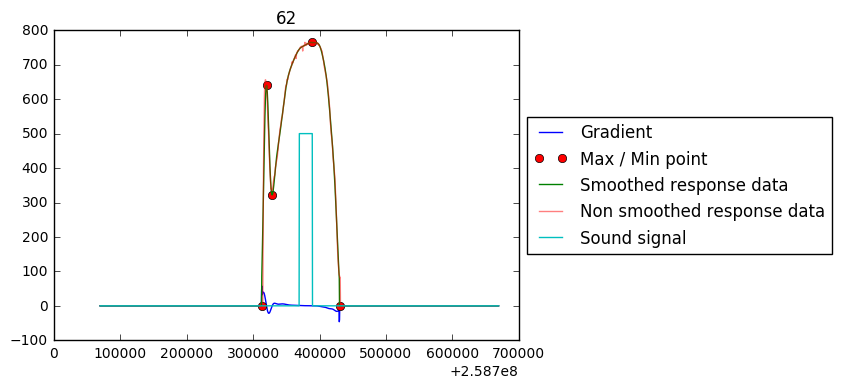

Error in detecting peaks


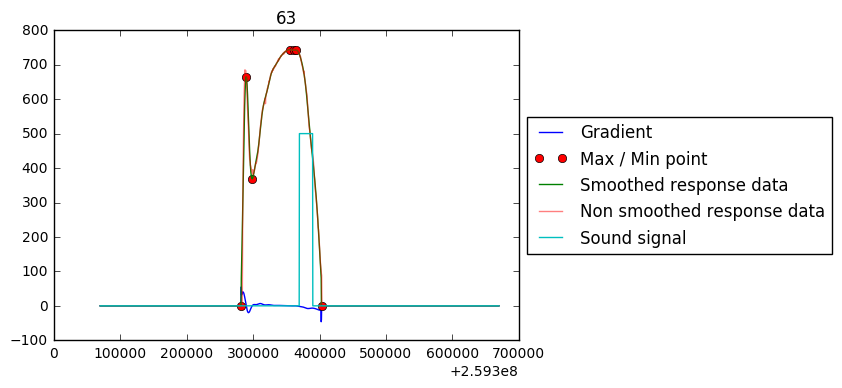

   onset_time  first_peak_time   dip_time  second_peak_time  offset_time
0   260175908        260183468  260192468         260264828    260308748


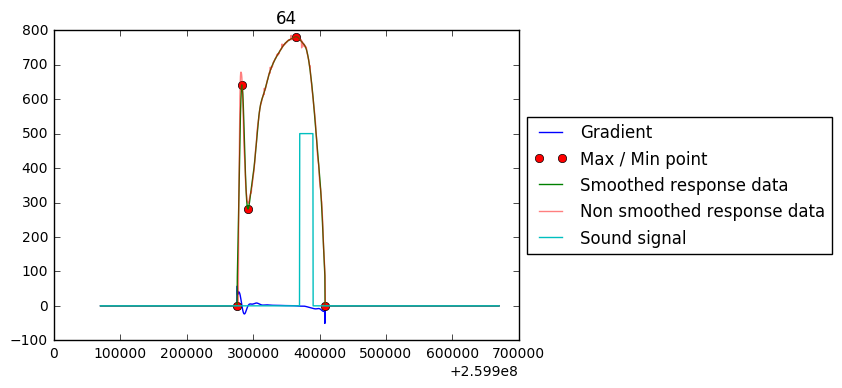

   onset_time  first_peak_time   dip_time  second_peak_time  offset_time
0   260764508        260772068  260781788         260843348    260882228


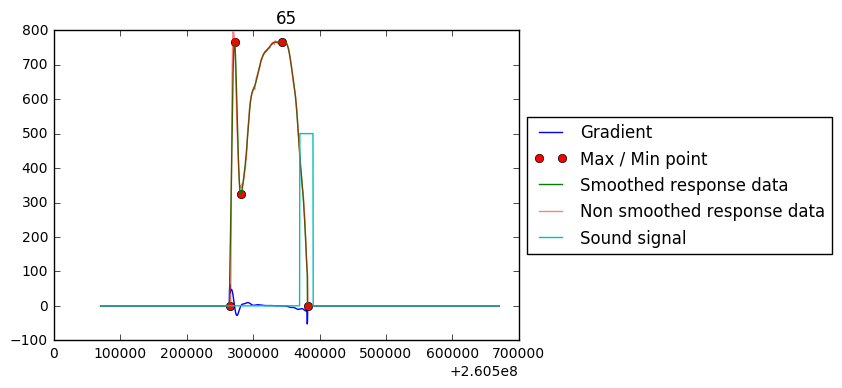

   onset_time  first_peak_time   dip_time  second_peak_time  offset_time
0   261354548        261362108  261371108         261428348    261469388


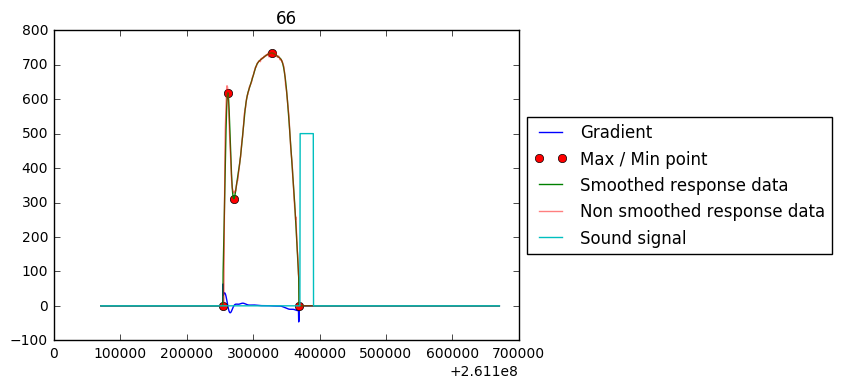

   onset_time  first_peak_time   dip_time  second_peak_time  offset_time
0   262555508        262563068  262571708         262623908    262665668


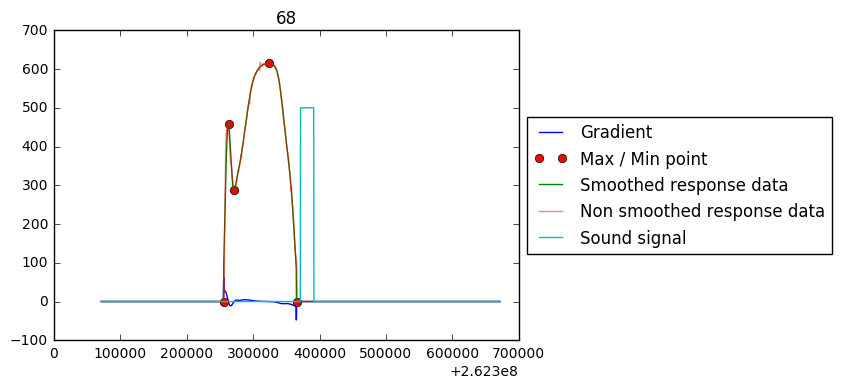

   onset_time  first_peak_time   dip_time  second_peak_time  offset_time
0   263102708        263110268  263118908         263179028    263214308


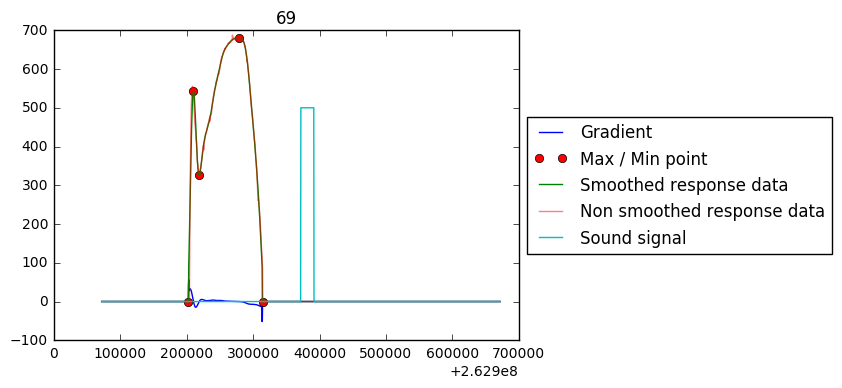

   onset_time  first_peak_time   dip_time  second_peak_time  offset_time
0   265567628        265575548  265584188         265625588    265664828


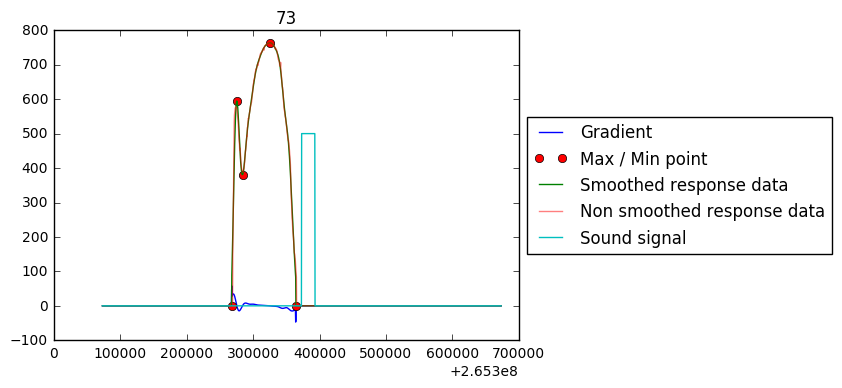

   onset_time  first_peak_time   dip_time  second_peak_time  offset_time
0   266188268        266195828  266204108         266261348    266308508


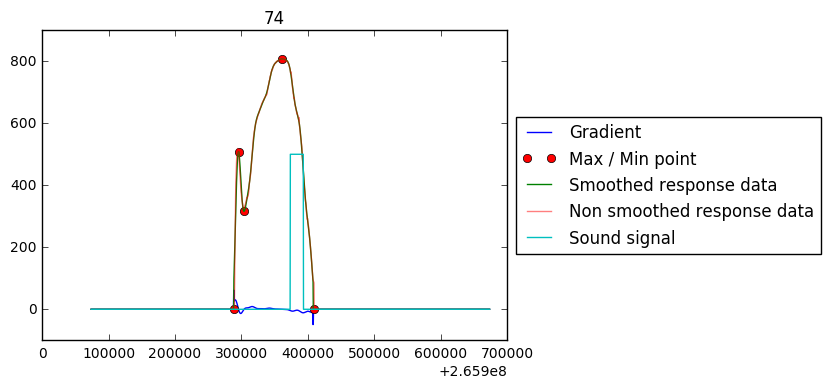

   onset_time  first_peak_time   dip_time  second_peak_time  offset_time
0   266748068        266755988  266764268         266824748    266868668


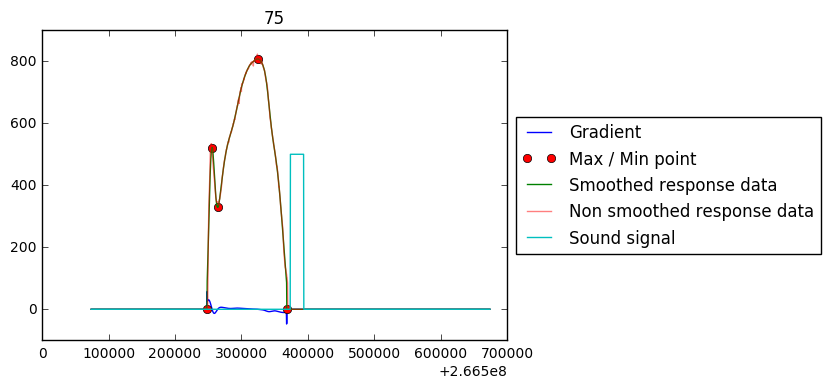

   onset_time  first_peak_time   dip_time  second_peak_time  offset_time
0   267379148        267386708  267394628         267451868    267496508


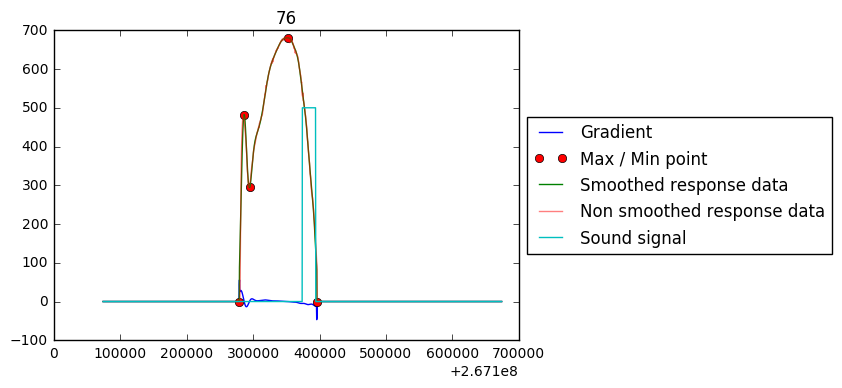

   onset_time  first_peak_time   dip_time  second_peak_time  offset_time
0   267970628        267978188  267987548         268043708    268089068


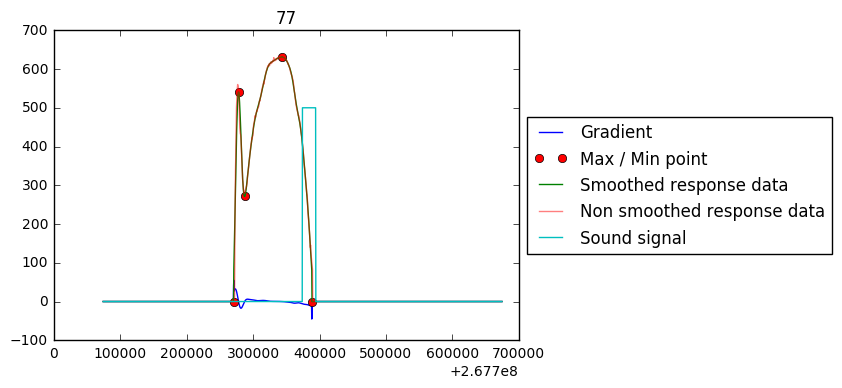

   onset_time  first_peak_time   dip_time  second_peak_time  offset_time
0   268467068        268474988  268483268         268563908    268614668


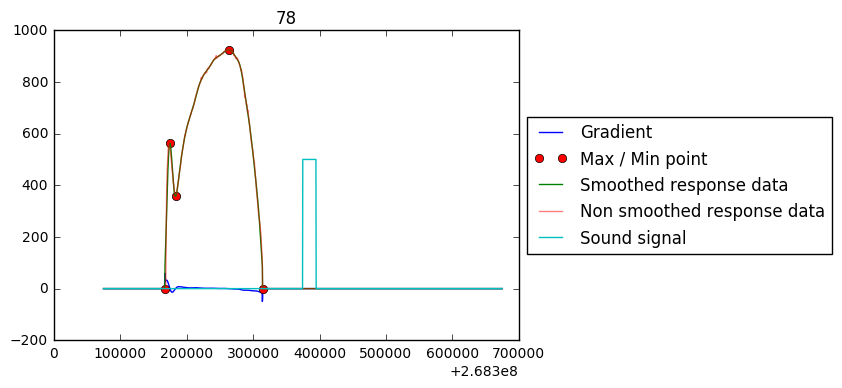

   onset_time  first_peak_time   dip_time  second_peak_time  offset_time
0   269062148        269069708  269078348         269165108    269224508


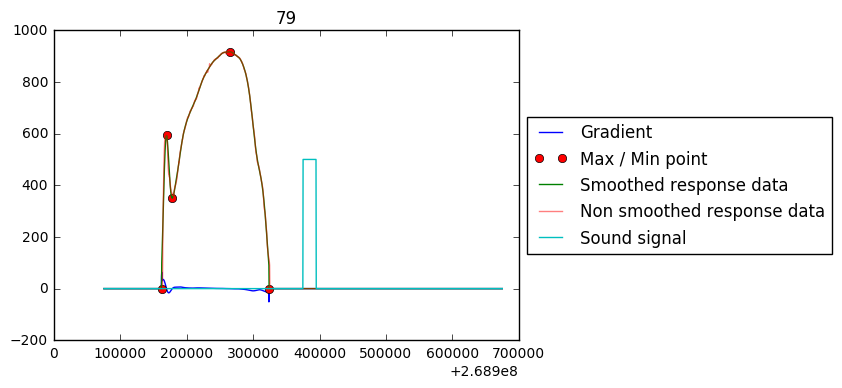

   onset_time  first_peak_time   dip_time  second_peak_time  offset_time
0   269726348        269733908  269742548         269788988    269839388


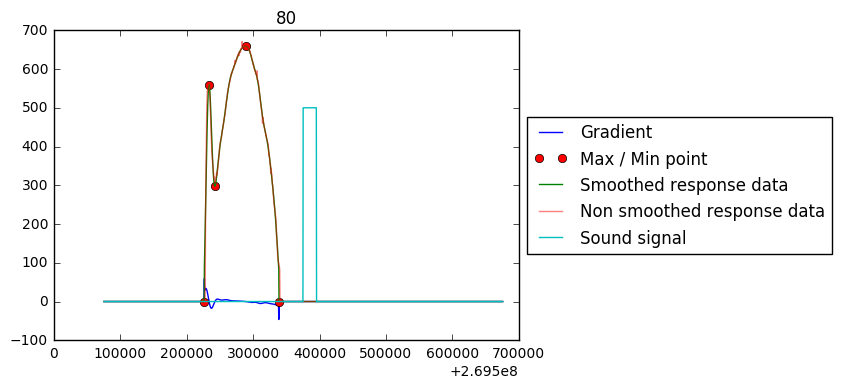

   onset_time  first_peak_time   dip_time  second_peak_time  offset_time
0   270298748        270306308  270314588         270395228    270440948


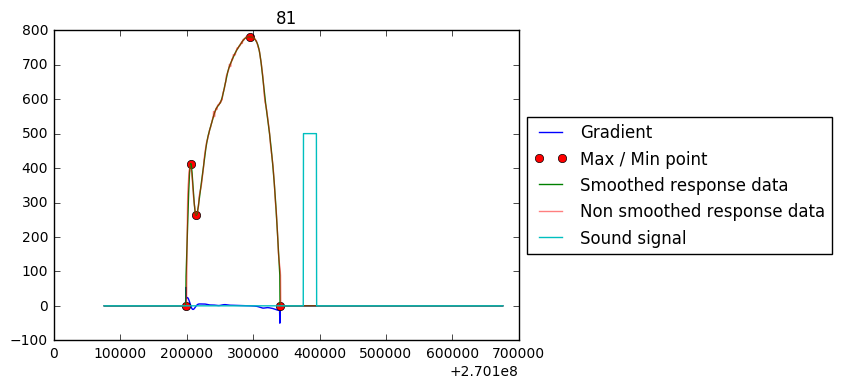

   onset_time  first_peak_time   dip_time  second_peak_time  offset_time
0   271557668        271565228  271574588         271636508    271683308


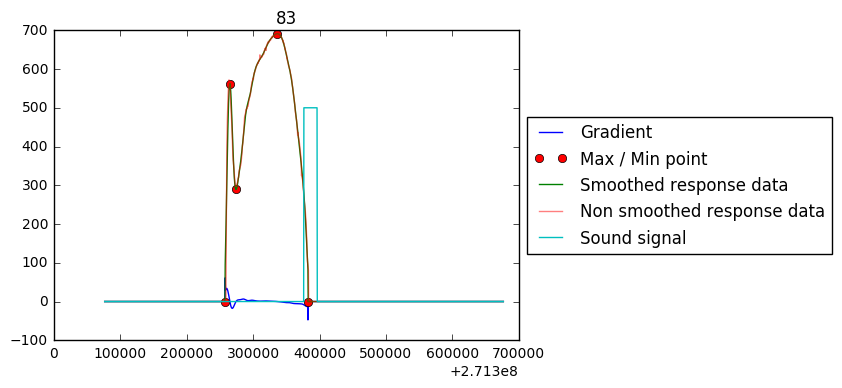

   onset_time  first_peak_time   dip_time  second_peak_time  offset_time
0   272208548        272216108  272225468         272271548    272311148


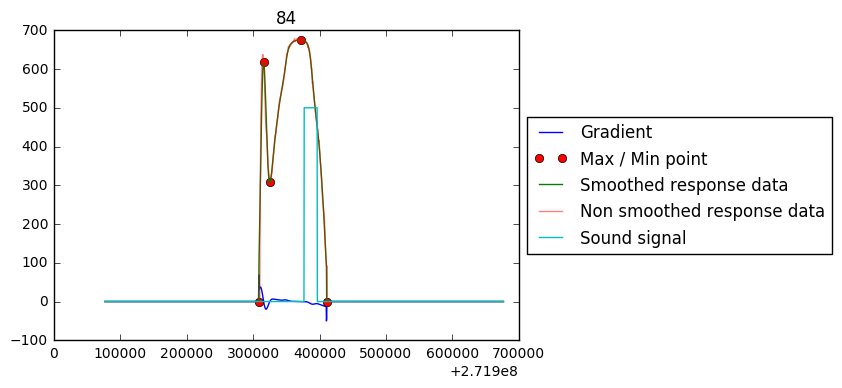

   onset_time  first_peak_time   dip_time  second_peak_time  offset_time
0   272806508        272814068  272823428         272883548    272926388


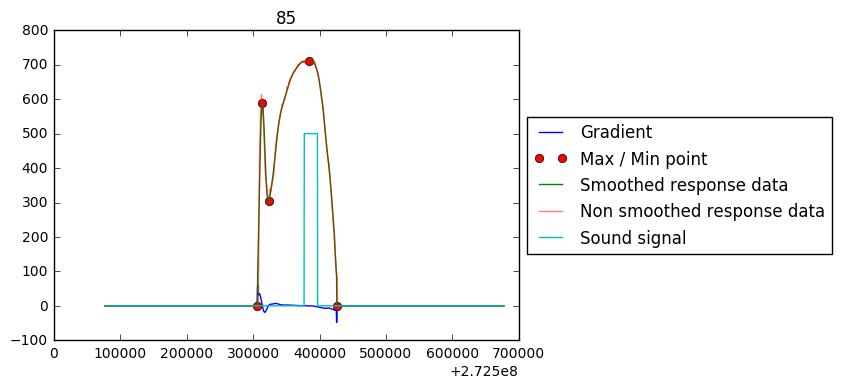

   onset_time  first_peak_time   dip_time  second_peak_time  offset_time
0   273387908        273395468  273404468         273479708    273526508


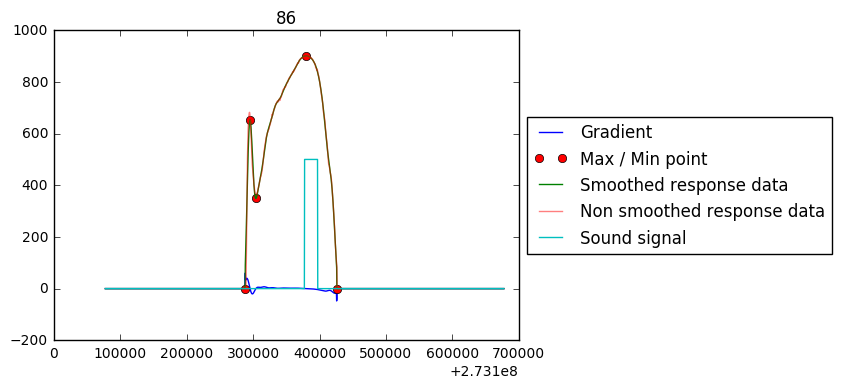

   onset_time  first_peak_time   dip_time  second_peak_time  offset_time
0   274056428        274063628  274072628         274120508    274165508


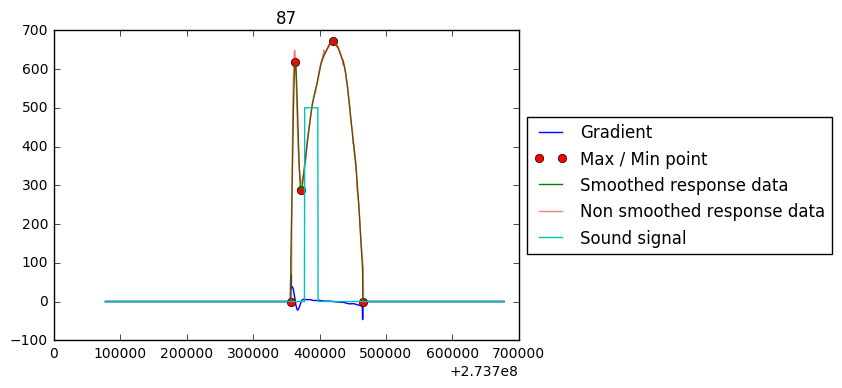

   onset_time  first_peak_time   dip_time  second_peak_time  offset_time
0   274566908        274574468  274583468         274656908    274705148


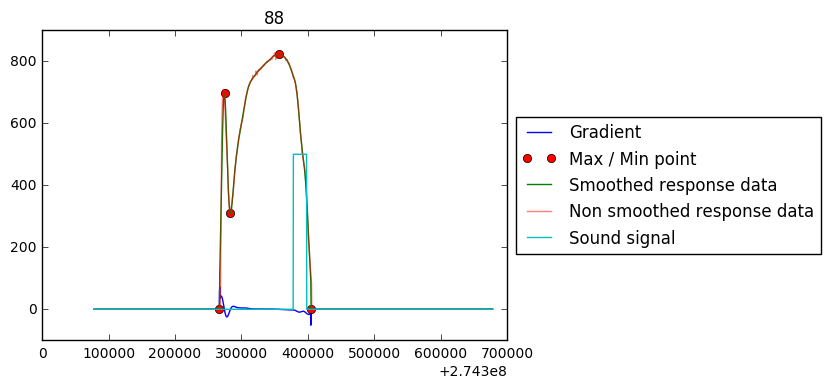

   onset_time  first_peak_time   dip_time  second_peak_time  offset_time
0   279939908        279947468  279956828         280018028    280060148


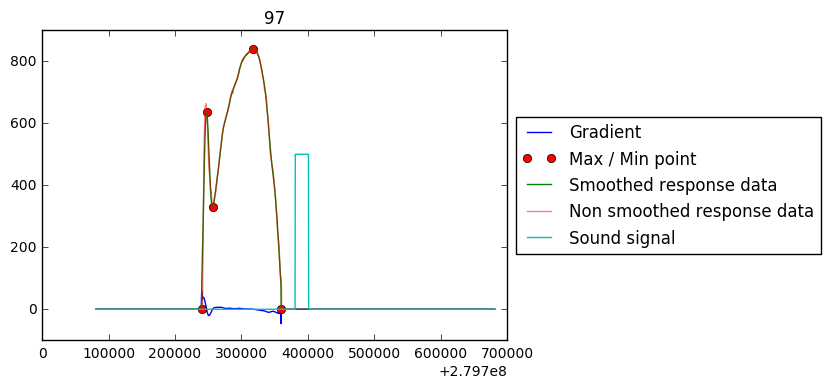

   onset_time  first_peak_time   dip_time  second_peak_time  offset_time
0   282909188        282916748  282925748         282973268    283013948


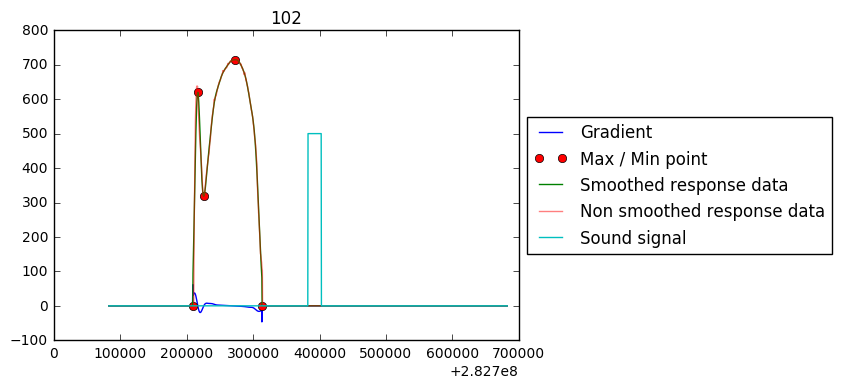

   onset_time  first_peak_time   dip_time  second_peak_time  offset_time
0   283475108        283482668  283492028         283538468    283585988


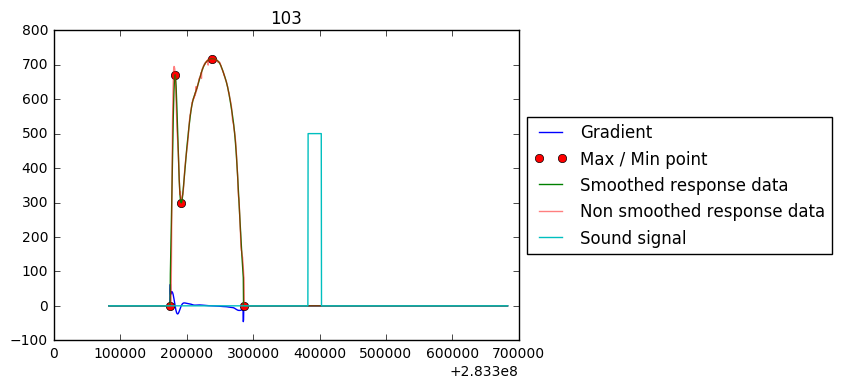

   onset_time  first_peak_time   dip_time  second_peak_time  offset_time
0   284115188        284123108  284131388         284186108    284233988


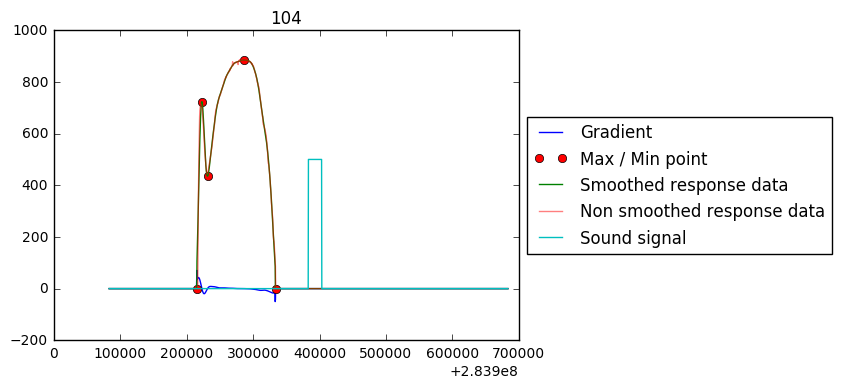

   onset_time  first_peak_time   dip_time  second_peak_time  offset_time
0   286549868        286557428  286566428         286614668    286655708


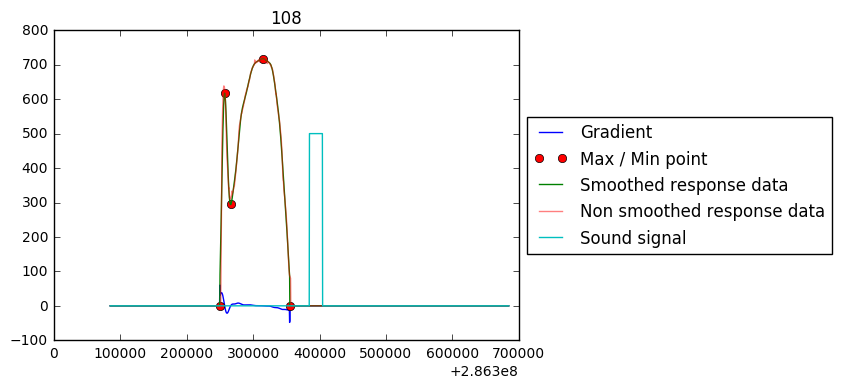

   onset_time  first_peak_time   dip_time  second_peak_time  offset_time
0   287129828        287137748  287146748         287190668    287246108


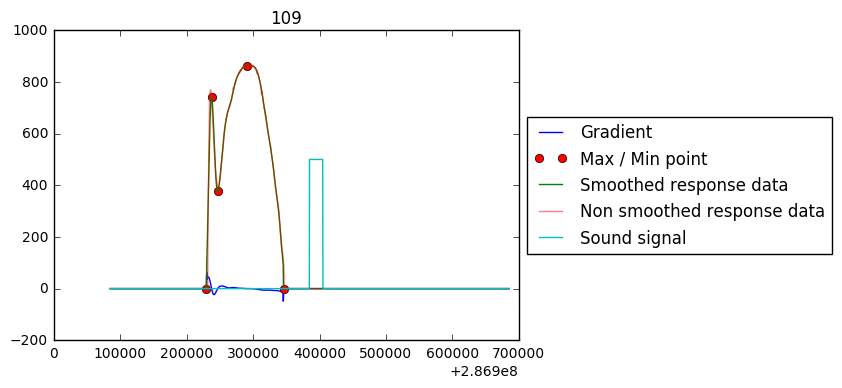

   onset_time  first_peak_time   dip_time  second_peak_time  offset_time
0   288487028        288495308  288502868         288556868    288609068


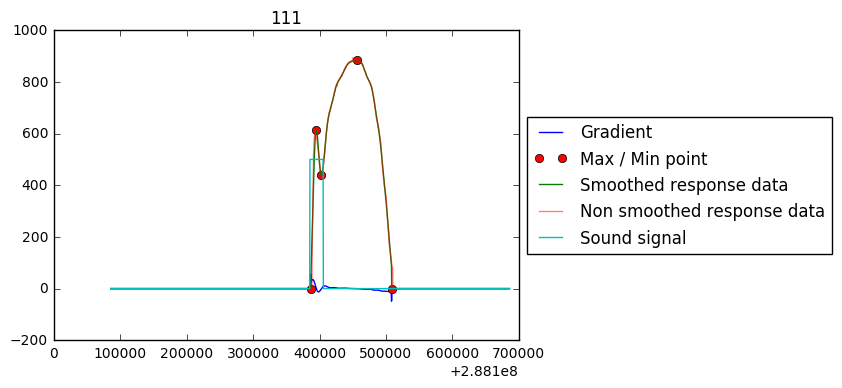

   onset_time  first_peak_time   dip_time  second_peak_time  offset_time
0   289114868        289122788  289128908         289170668    289237268


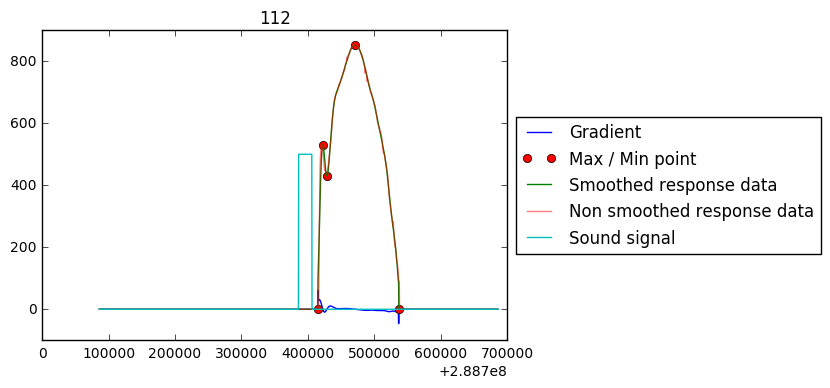

   onset_time  first_peak_time   dip_time  second_peak_time  offset_time
0   289698428        289705988  289714628         289813268    289877708


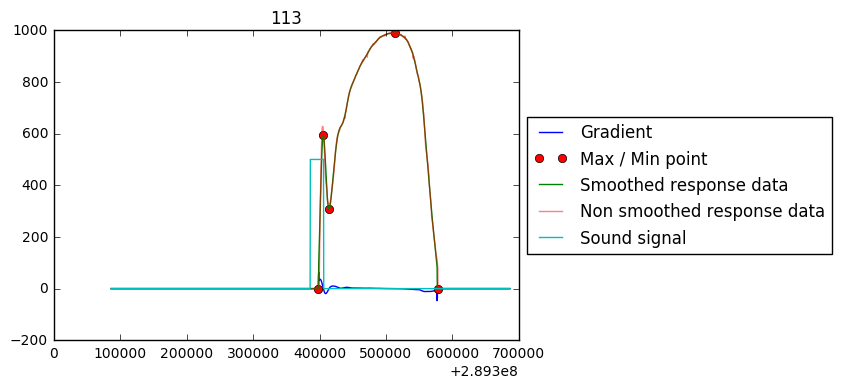

   onset_time  first_peak_time   dip_time  second_peak_time  offset_time
0   290424188        290431748  290440388         290505548    290557388


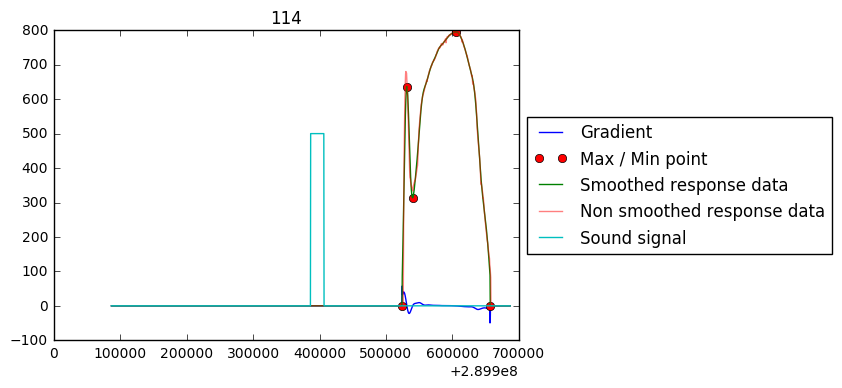

   onset_time  first_peak_time   dip_time  second_peak_time  offset_time
0   290990108        290997668  291005948         291083348    291142748


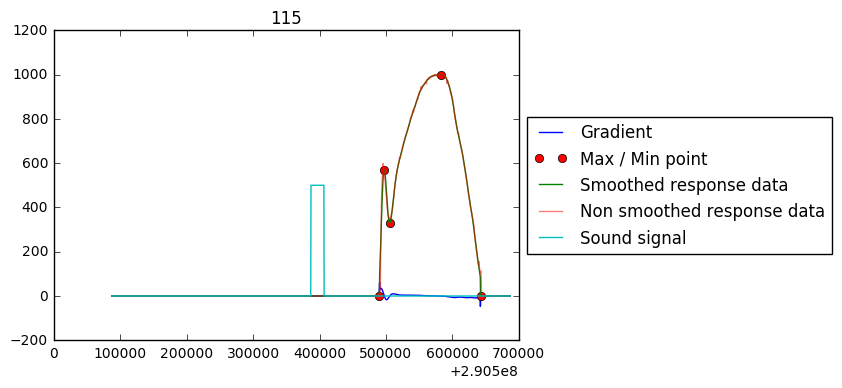

   onset_time  first_peak_time   dip_time  second_peak_time  offset_time
0   291513548        291521108  291527948         291576548    291628748


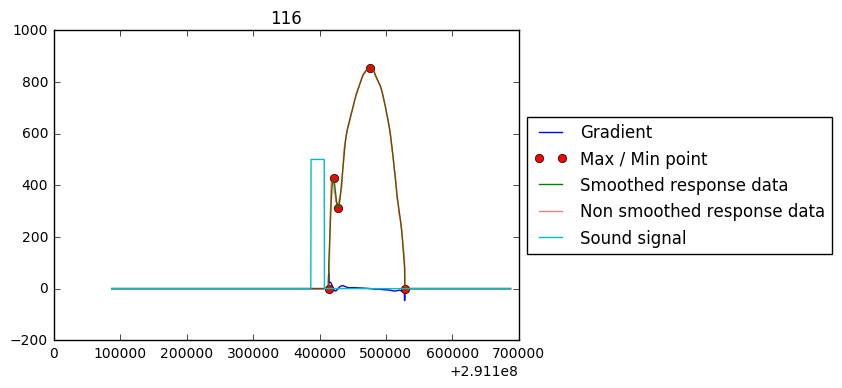

In [ ]:
for num, df_tmp in enumerate(data_split):
    if df_tmp['svolt(fsr)[v]'].mean() < 80:
        pass
    else:       
        # Point of sign change in gradient (max / min point)
        asign = np.sign(df_tmp['gradient'])
        signchange = ((np.roll(asign, 1) - asign) !=0).astype(int)

        if np.sum(signchange) == 5:
            max_min_index = signchange[signchange==1].index.values
            max_min_time = df_tmp.ix[signchange[signchange==1].index.values, 'time[us]'].values
            onset_time, first_peak_time, dip_time, second_peak_time, offset_time = max_min_time
#             print(onset_time, first_peak_time, dip_time, second_peak_time, offset_time)
            df_char_tmp = pd.DataFrame([onset_time, first_peak_time, dip_time, second_peak_time, offset_time]).T
            df_char_tmp.columns = ['onset_time', 'first_peak_time', 'dip_time', 'second_peak_time', 'offset_time']
            print(df_char_tmp)
        else:
            print('Error in detecting peaks')
            pass
        
        # Plot gradient
        plt.plot(df_tmp['time[us]'], df_tmp['gradient'], label='Gradient')        

        # Plot sign change point
        plt.plot(df_tmp['time[us]'][signchange[signchange==1].index.values], 
                 df_tmp['svolt(fsr)[v]'][signchange[signchange==1].index.values], 'ro', label='Max / Min point')

        # Plot smoothed response data
        plt.plot(df_tmp['time[us]'], df_tmp['svolt(fsr)[v]'], label='Smoothed response data')

        # Plot non-smoothed response data
        plt.plot(df_tmp['time[us]'], df_tmp['volt(fsr)[v]'], label='Non smoothed response data', alpha=0.5)

        # Sound signal
        plt.plot(df_tmp['time[us]'], df_tmp['signal'] * 500, label = 'Sound signal')

        plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
        plt.title(num)
        plt.show()



# Ignore below for now

## Peak estimation in the raw data

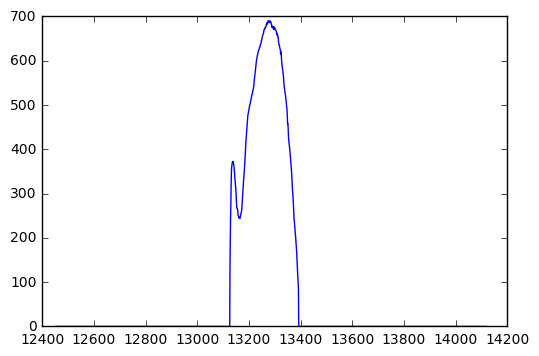

In [423]:
plt.plot(data_split[8]['volt(fsr)[v]'])

In [365]:
indexes

array([687, 711, 899])

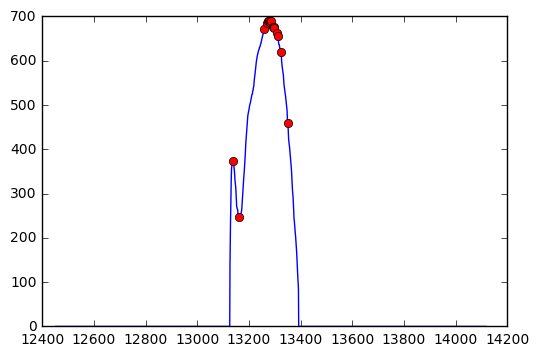

In [397]:
plt.plot(data_split[8]['volt(fsr)[v]'])
indexes = peakutils.indexes(data_split[8]['volt(fsr)[v]'], thres=0.1)

plt.plot(data_split[8].index.values[indexes], data_split[8]['volt(fsr)[v]'].values[indexes], 'ro')


In [410]:
indexes[np.abs(np.gradient(data_split[8]['volt(fsr)[v]'])[indexes]).argmin()]

829

In [400]:
len(data_split[8])

1667

In [411]:
len(np.gradient(data_split[8]['volt(fsr)[v]']))

1667

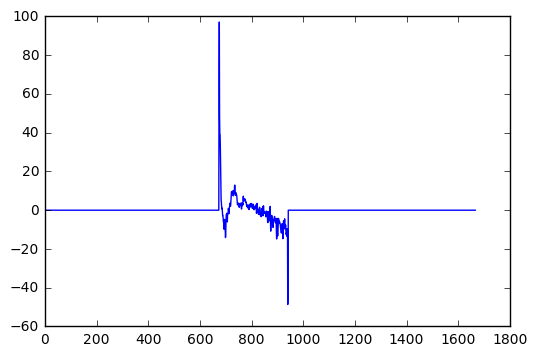

In [390]:
plt.plot(np.gradient(data_split[8]['volt(fsr)[v]']))

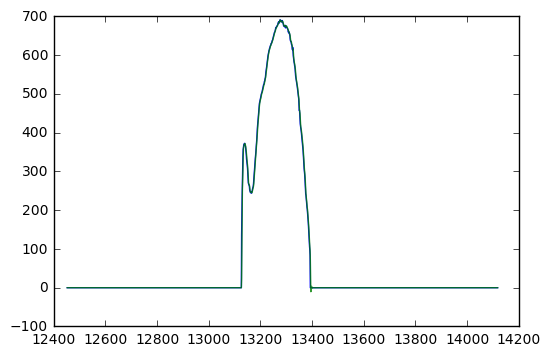

In [460]:
plt.plot(data_split[8].index.values, data_split[8]['volt(fsr)[v]'])
plt.plot(data_split[8].index.values, butter_lowpass_filter(data_split[8]['volt(fsr)[v]'], 200, 800, 3), alpha=0.8)

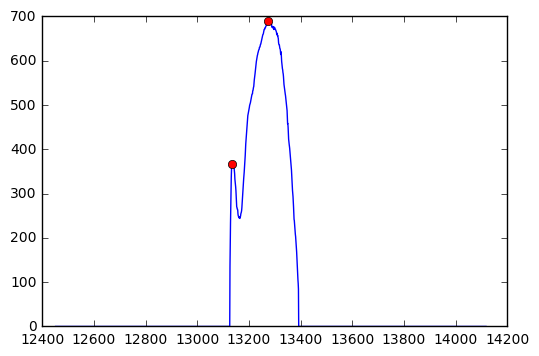

In [500]:
peaks = find_peaks_cwt(data_split[8]['volt(fsr)[v]'], np.arange(1,30))
peaks = [peaks[0]] + [peaks[data_split[8]['volt(fsr)[v]'].values[peaks].argmax()]]
plt.plot(data_split[8].index.values, data_split[8]['volt(fsr)[v]'])
plt.plot(data_split[8].index.values[peaks], data_split[8]['volt(fsr)[v]'].values[peaks], 'ro')

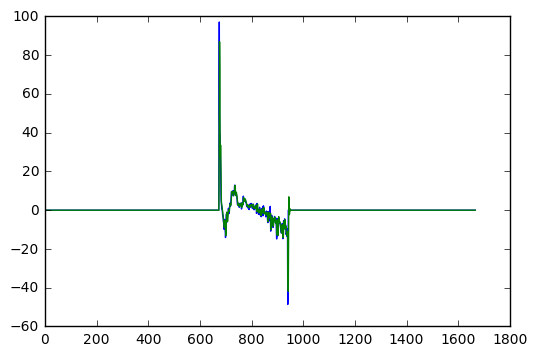

In [470]:
plt.plot(np.gradient(data_split[8]['volt(fsr)[v]']))
plt.plot(butter_lowpass_filter(np.gradient(data_split[8]['volt(fsr)[v]']), 200, 800, 3))

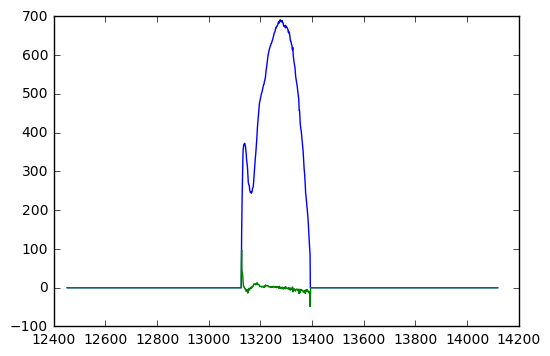

In [413]:
plt.plot(data_split[8]['volt(fsr)[v]'].index, data_split[8]['volt(fsr)[v]'])
plt.plot(data_split[8]['volt(fsr)[v]'].index, np.gradient(data_split[8]['volt(fsr)[v]']))

In [435]:
data_split[8].ix[(data_split[8]['volt(fsr)[v]'] > 0)]['gradient'].abs().argmin()


13165

In [443]:
data_split[8].ix[(data_split[8]['volt(fsr)[v]'] > 0)]['gradient'].abs().sort_values()

13165     0.023611
13299     0.065934
13281     0.067467
13275     0.101939
13280     0.145429
13163     0.253213
13282     0.282730
13260     0.311634
13263     0.313019
13272     0.326389
13242     0.334715
13284     0.373270
13309     0.466807
13277     0.565928
13290     0.590411
13213     0.606648
13311     0.656707
13137     0.695091
13317     0.701370
13291     0.728022
13276     0.753315
13292     0.754795
13294     0.796259
13162     0.876389
13255     0.981102
13302     1.002740
13239     1.002770
13297     1.010870
13300     1.027397
13138     1.038039
           ...    
13150    10.519668
13391    10.622961
13326    10.800000
13385    11.133137
13366    11.236111
13352    11.336565
13348    11.345833
13372    11.481887
13387    11.715278
13367    11.740997
13368    11.745845
13152    11.900000
13133    12.364716
13186    12.502778
13386    12.544737
13389    12.865278
13187    12.968144
13353    13.222222
13388    13.401662
13374    14.030556
13151    14.115651
13373    14.

243.86980609418282

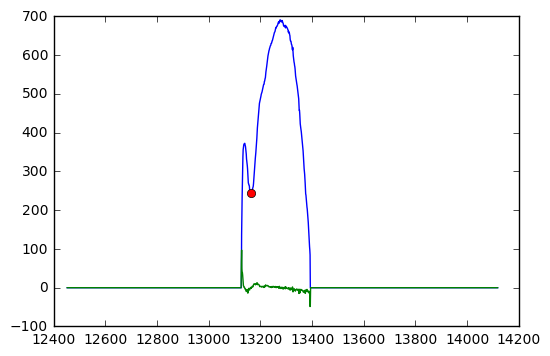

In [440]:
plt.plot(data_split[8]['volt(fsr)[v]'].index, data_split[8]['volt(fsr)[v]'])
plt.plot(data_split[8]['volt(fsr)[v]'].index, np.gradient(data_split[8]['volt(fsr)[v]']))
plt.plot(13165, data_split[8].ix[13165, 'volt(fsr)[v]'], 'ro')

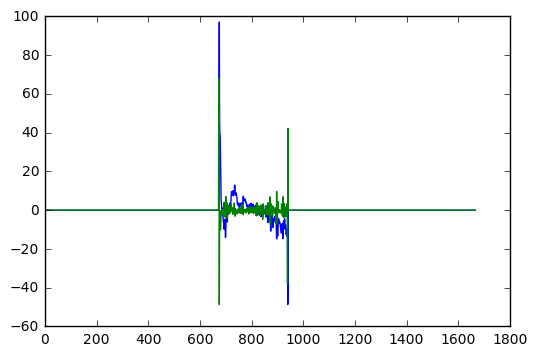

In [395]:
plt.plot(np.gradient(data_split[8]['volt(fsr)[v]']))
plt.plot(np.ediff1d(np.gradient(data_split[8]['volt(fsr)[v]'])))

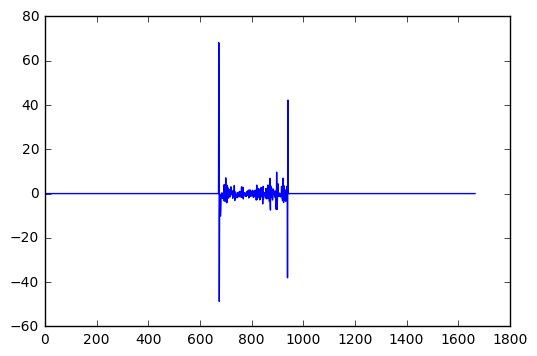

In [396]:
plt.plot(np.ediff1d(np.gradient(data_split[8]['volt(fsr)[v]'])))

In [355]:
from scipy import signal

In [356]:
np.arange(0, len(data_split[8]), 300)

array([   0,  300,  600,  900, 1200, 1500])

In [357]:
signal.find_peaks_cwt(data_split[8]['volt(fsr)[v]'], np.arange(1, 450))

[869]

In [358]:
data_split[8]['volt(fsr)[v]'][data_split[8].index.values[signal.find_peaks_cwt(data_split[8]['volt(fsr)[v]'], np.arange(1, 300))]]

13321    627.0
Name: volt(fsr)[v], dtype: float64

In [359]:
data_split[8]['volt(fsr)[v]'].index.values

array([12452, 12453, 12454, ..., 14116, 14117, 14118])

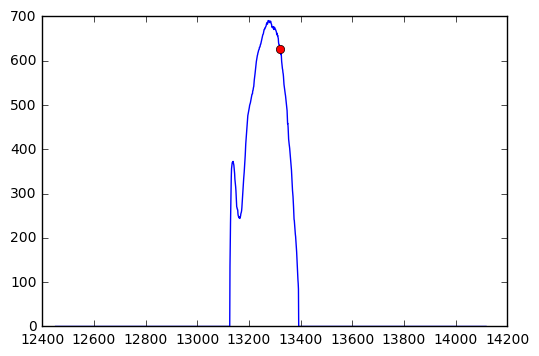

In [360]:
plt.plot(data_split[8]['volt(fsr)[v]'])
plt.plot(data_split[8].index.values[signal.find_peaks_cwt(data_split[8]['volt(fsr)[v]'], np.arange(1, 2000))],
         data_split[8]['volt(fsr)[v]'][data_split[8].index.values[signal.find_peaks_cwt(data_split[8]['volt(fsr)[v]'], np.arange(1, 2000))]],
         'ro')
# data_split[8].index.values[835]

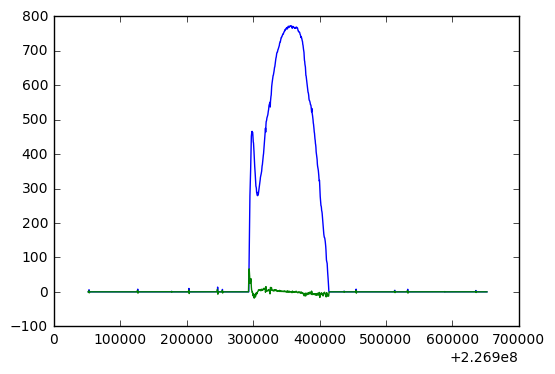

In [153]:
plt.plot(data_split[8]['time[us]'], data_split[8]['volt(fsr)[v]'])
plt.plot(data_split[8]['time[us]'], np.gradient(data_split[8]['volt(fsr)[v]']))
# data_split[8].index.values[835]

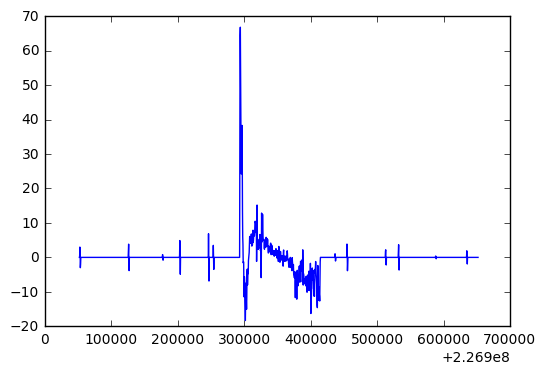

In [154]:
plt.plot(data_split[8]['time[us]'], np.gradient(data_split[8]['volt(fsr)[v]']))

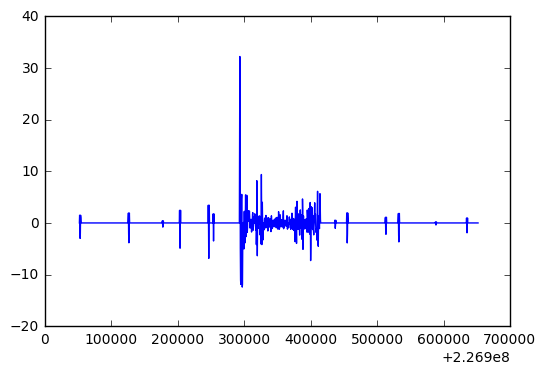

In [155]:
plt.plot(data_split[8]['time[us]'], np.gradient(np.gradient(data_split[8]['volt(fsr)[v]'])))

> ## Smoothing

KeyError: 0

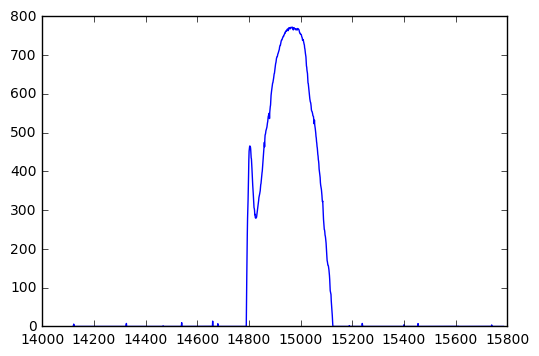

In [165]:
plt.plot(data_split[8]['volt(fsr)[v]'])
plt.plot(savitzky_golay(data_split[8]['volt(fsr)[v]'], 101, 3))

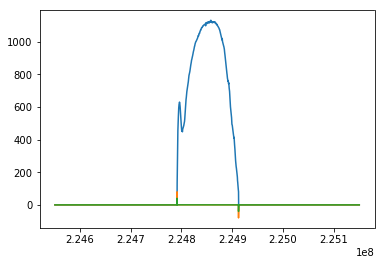

In [828]:
plt.plot(df_tmp.index, df_tmp['volt(fsr)[v]'])
plt.plot(df_tmp.index[1:], np.ediff1d(df_tmp['volt(fsr)[v]']))
plt.plot(df_tmp.index, np.gradient(df_tmp['volt(fsr)[v]']))

In [853]:
np.gradient(df_tmp['volt(fsr)[v]'])

array([ 0.,  0.,  0., ...,  0.,  0.,  0.])

In [855]:
np.gradient?

In [863]:
peakData = indexes(data['volt(fsr)[v]'])

In [864]:
peakData.shape

(4621,)

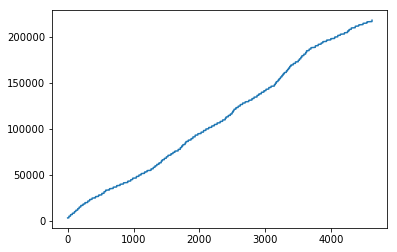

In [866]:
plt.plot(peakData)

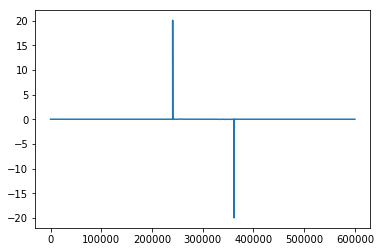

In [856]:
plt.plot(np.gradient(df_tmp['volt(fsr)[v]'], 2))

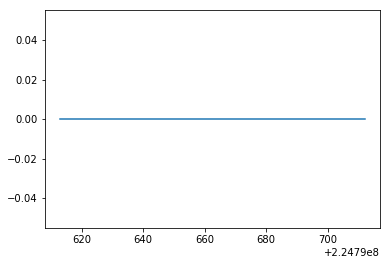

In [852]:
# plt.plot(df_tmp.index[:300000], df_tmp['volt(fsr)[v]'][:300000])
plt.plot(df_tmp.index[240000:240100], np.gradient(df_tmp['volt(fsr)[v]'][240000:240100]))

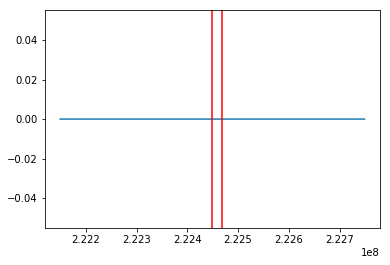

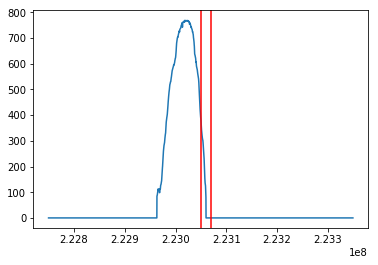

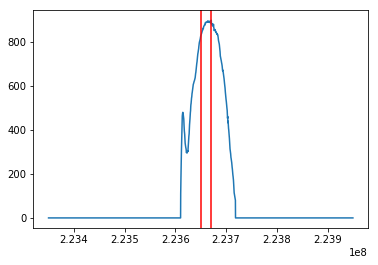

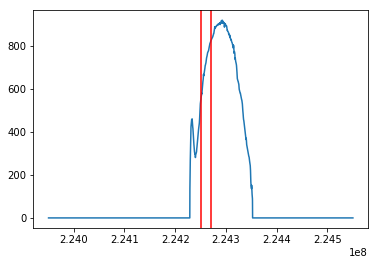

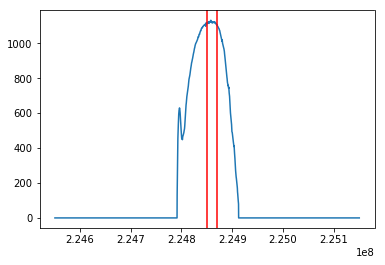

In [813]:
for signal_on_first, signal_on_last in zip(signal_first_ones_time[:5],
                                           signal_last_ones_time[:5]):
    df_tmp = data_thr.loc[signal_on_first - cut_window : signal_on_first + cut_window]
    plt.plot(df_tmp['volt(fsr)[v]'])
    plt.axvline(signal_on_first, color = 'r')
    plt.axvline(signal_on_last, color = 'r')
    
    print(np.gradient(df_tmp['volt(fsr)[v]']))
    # Peak
#     peak = indexes(df_tmp['volt(fsr)[v]'], thres=0.3, min_dist=100000)
#     print(peak)
    plt.show()

In [508]:
indexes(data_split[0]['volt(fsr)[v]'], thres=0.999, min_dist=len(data_split[0]))

array([566])

In [506]:
df = pd.DataFrame()
for num, (df, onset_marker) in enumerate(zip(data_split[:5],
                                             signal_first_ones_index[:5])):

    response_peak_index = indexes(df['volt(fsr)[v]'],
                                  thres=0.999, 
                                  min_dist=len(df))
    
    p

time[us]  volt(fsr)[v]  signal  signal frequency[Hz]
0  221869028             0       0                  1000
1  221869389             0       0                  1000
2  221869750             0       0                  1000
3  221870110             0       0                  1000
4  221870470             0       0                  1000

In [502]:
len(data_split)

132

In [ ]:
# window span = onset +- onset_diff/2
onset_index = data['time[us]'].loc[high_peak_indexes].index.values
onset_index_diff_div2 = np.ediff1d(onset_index)/2
onset_index_diff_div2_round = np.round(onset_index_diff_div2)

window_span_index = onset_index[:-1] + onset_index_diff_div2_round

# split the data using the window_span_index
subject_response_series = data['volt(fsr)[v]']
subject_response_index = subject_response_series.index.values
subject_response_index_split = np.split(subject_response_index, 
                                        window_span_index.astype('int'))
subject_response_data = [subject_response_series.loc[x] for x in subject_response_index_split]

signal_data = [signal_data.loc[x] for x in subject_response_index_split]

In [496]:
# difference between consecutive element
pre_post_signal_diff = np.ediff1d(data['signal'])

# where the difference is +1 : Signal turning on (0 --> 1)
# 1 has been added to return the index of first 'on'
signal_first_ones_index = np.where(pre_post_signal_diff==1)[0] + 1
data.loc[signal_first_ones_index, 'signal_timing'] = 'first_on'

# where the difference is -1 : Signal turning off (1 --> 0)
signal_last_ones_index = np.where(pre_post_signal_diff==-1)[0]
data.loc[signal_last_ones_index, 'signal_timing'] = 'last_on'

In [497]:
data['signal_timing'].unique()

array([nan, 'first_on', 'last_on'], dtype=object)

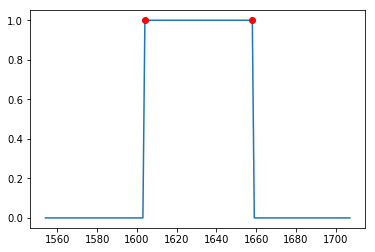

In [478]:
plt.plot(data['signal'][signal_first_ones_index[0]-50:signal_last_ones_index[0]+50])
plt.plot(signal_first_ones_index[0], 1, 'ro')
plt.plot(signal_last_ones_index[0], 1, 'ro')

In [408]:
len(data[data['signal']==1]['time[us]'])

7151

In [406]:
np.ediff1d(data[data['signal']==1]['time[us]'])>10000

array([False, False, False, ..., False, False,  True], dtype=bool)

In [390]:
data[data['signal']==1]['time[us]'].loc[1604]

222449262.0

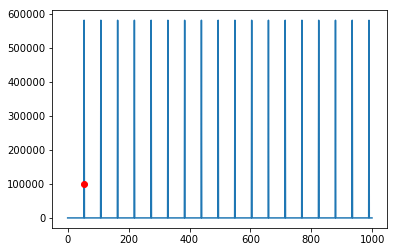

In [376]:
plt.plot(data['signal'])
plt.plot(np.ediff1d(data[data['signal']==1]['time[us]'])[:1000])
plt.plot(54, 100000, 'ro')
plt.show()

> Estimate gradient

In [293]:
signal_gradient = np.gradient(data['signal'])

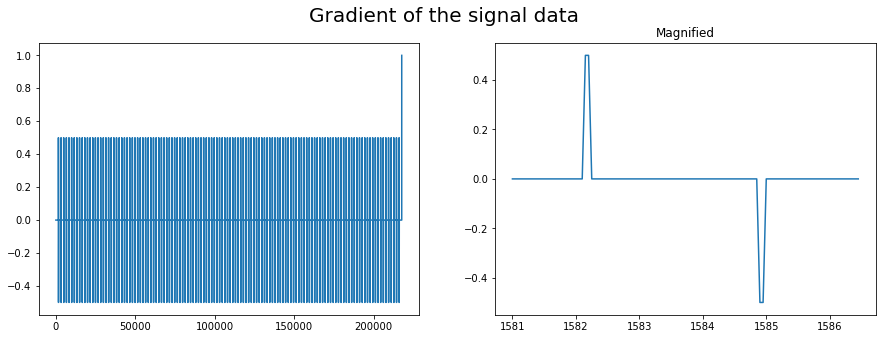

In [296]:
fig, axes = plt.subplots(ncols=2, 
                         figsize=(15,5))
axes[0].plot(signal_gradient)
axes[1].plot(signal_gradient[1580:1690])
axes[1].set_title('Magnified')
axes[1].set_xticklabels(data['signal'].index.values[1580:1690])
fig.suptitle('Gradient of the signal data', fontsize=20)

plt.show()

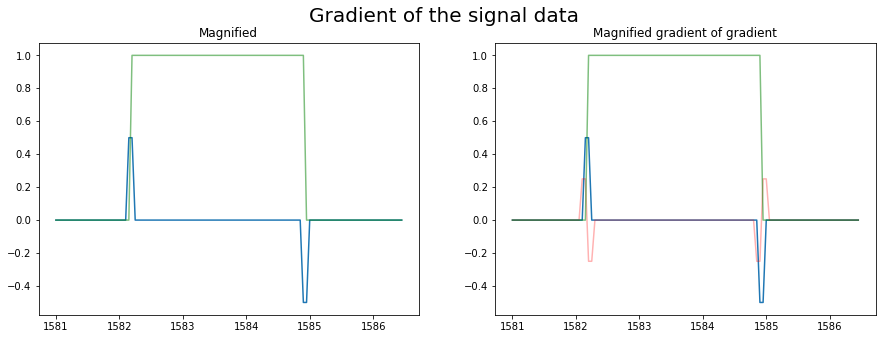

In [342]:
fig, axes = plt.subplots(ncols=2, 
                         figsize=(15,5))

axes[0].plot(signal_gradient[1580:1690])
axes[0].plot(data['signal'].values[1580:1690], 
             'g', 
             alpha=0.5)

axes[0].set_title('Magnified')
axes[0].set_xticklabels(data['signal'].index.values[1580:1690])

axes[1].plot(signal_gradient[1580:1690])
axes[1].plot(np.gradient(signal_gradient)[1580:1690], 'r', alpha=0.3)
axes[1].plot(data['signal'].values[1580:1690], 
             'g', 
             alpha=0.5)

axes[1].set_title('Magnified gradient of gradient')
axes[1].set_xticklabels(data['signal'].index.values[1580:1690])


fig.suptitle('Gradient of the signal data', fontsize=20)

plt.show()

- Positive peak : onset time
- Negative peak : offset time
- Time between those two peaks : duration

> Peak estimation of the signal gradient data

In [96]:
high_peak_indexes = indexes(signal_gradient, thres=0.3, min_dist=1000)
low_peak_indexes = indexes(-signal_gradient, thres=0.3, min_dist=1000)

> Plot the gradient data

In [307]:
high_peak_indexes[0]

1603

In [311]:
low_peak_indexes[0]

1658

In [313]:
[data['time[us]'].values[1603], data['time[us]'].values[1658]]

[222448901.0, 222468959.0]

In [317]:
hot.set_xticks?

In [316]:
hot.set_xticklabels?

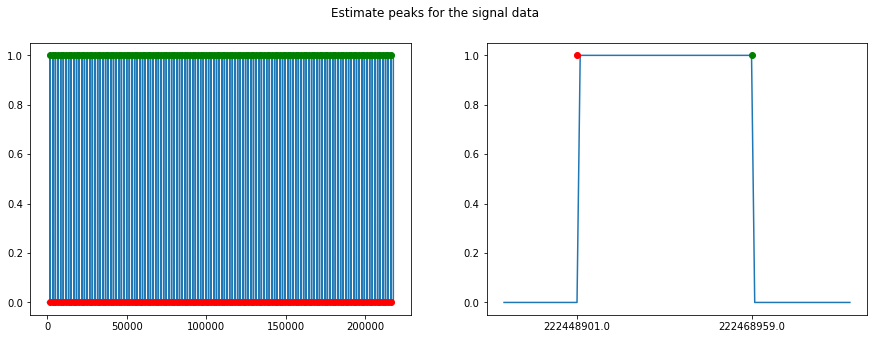

In [321]:
fig, axes = plt.subplots(ncols=2, figsize=(15,5))
axes[0].plot(data['signal'])
axes[0].plot(high_peak_indexes, data['signal'][high_peak_indexes], 'ro')
axes[0].plot(low_peak_indexes, data['signal'][low_peak_indexes], 'go')


axes[1].plot(data['signal'][1580:1690])
axes[1].plot(high_peak_indexes[0], data['signal'][high_peak_indexes[0]+1], 'ro')
axes[1].plot(low_peak_indexes[0], data['signal'][low_peak_indexes[0]], 'go')

axes[1].set_xticks([high_peak_indexes[0], low_peak_indexes[0]])
axes[1].set_xticklabels([data['time[us]'].values[1603], 
                         data['time[us]'].values[1658]])

plt.suptitle('Estimate peaks for the signal data')
plt.show()

> Return timing information

In [90]:
diff_onset = np.ediff1d(data['time[us]'].loc[high_peak_indexes])
diff_offset = np.ediff1d(data['time[us]'].loc[low_peak_indexes])
duration = data['time[us]'].loc[low_peak_indexes].values - data['time[us]'].loc[high_peak_indexes].values

print('Number of onsets : {}'.format(len(diff_onset)+1))
print('Number of offsets : {}'.format(len(diff_offset)+1))

Number of onsets : 130
Number of offsets : 130


In [91]:
tmp_df = pd.DataFrame({'Onset':[diff_onset.mean(), diff_onset.std()],
                      'Offset':[diff_offset.mean(), diff_offset.std()],
                      'Duration':[duration.mean(), duration.std()]}).T
tmp_df.columns = ['Mean [us]', 'Std [us]']
tmp_df

Mean [us]   Std [us]
Duration   20060.230769   1.638660
Offset    600330.937984  20.313341
Onset     600330.914729  20.130593

# Analysis 2 : Estimating subject reponse delay

In [63]:
peak_indexes = indexes(data['volt(fsr)[v]'], thres=0.3, min_dist=1000)

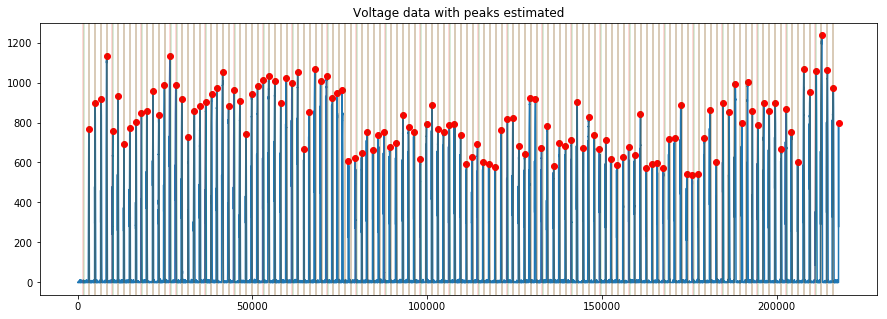

In [106]:
fig = plt.figure(figsize=(15,5))
plt.plot(data['volt(fsr)[v]'])
plt.plot(peak_indexes, data['volt(fsr)[v]'][peak_indexes], 'ro')

#sound on
for xc in high_peak_indexes:
    plt.axvline(x=xc, color='r', alpha=0.2)

#sound off
for xc in low_peak_indexes:
    plt.axvline(x=xc, color='g', alpha=0.2)

plt.title('Voltage data with peaks estimated')
plt.show()

In [66]:
print('Number of peaks : {}'.format(len(peak_indexes)))

Number of peaks : 130


> Split the subject reponse data 

- 2017_09_16

In [238]:
# window span = onset +- onset_diff/2
onset_index = data['time[us]'].loc[high_peak_indexes].index.values
onset_index_diff_div2 = np.ediff1d(onset_index)/2
onset_index_diff_div2_round = np.round(onset_index_diff_div2)

window_span_index = onset_index[:-1] + onset_index_diff_div2_round

# split the data using the window_span_index
subject_response_series = data['volt(fsr)[v]']
subject_response_index = subject_response_series.index.values
subject_response_index_split = np.split(subject_response_index, 
                                        window_span_index.astype('int'))
subject_response_data = [subject_response_series.loc[x] for x in subject_response_index_split]

signal_data = [signal_data.loc[x] for x in subject_response_index_split]

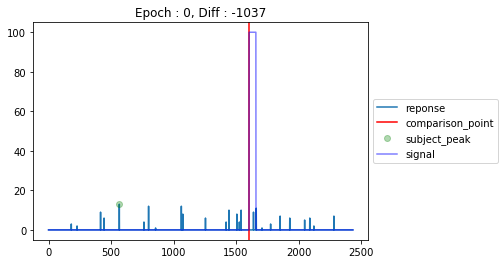

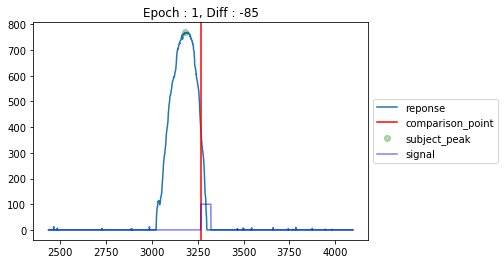

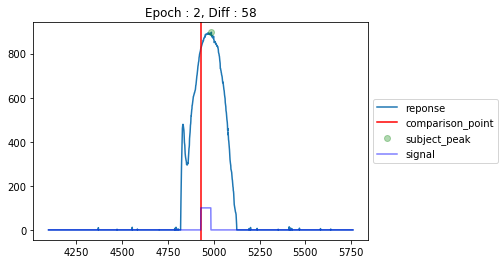

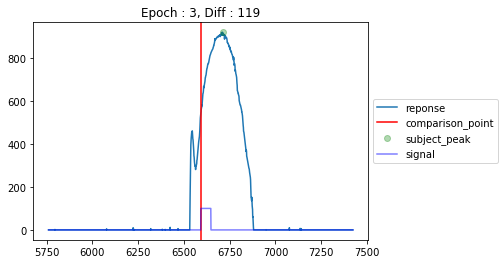

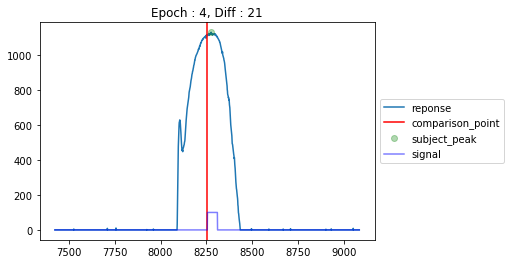

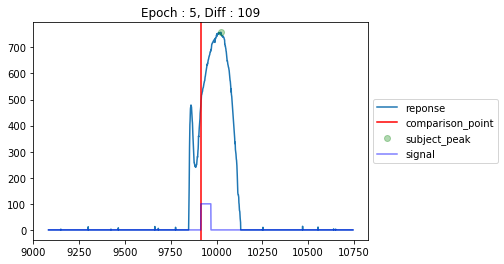

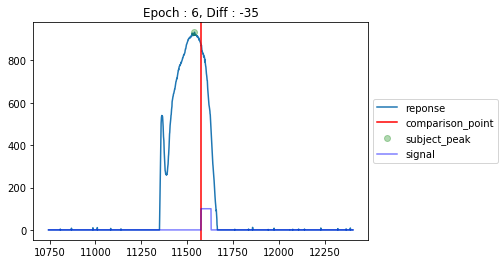

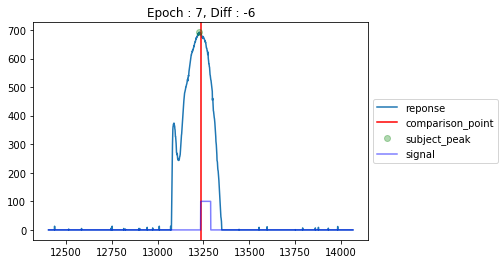

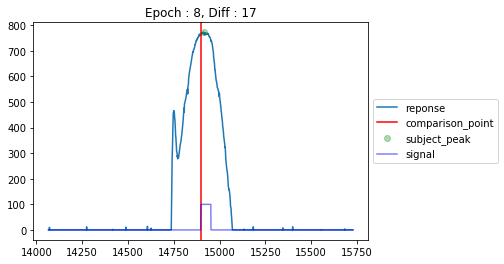

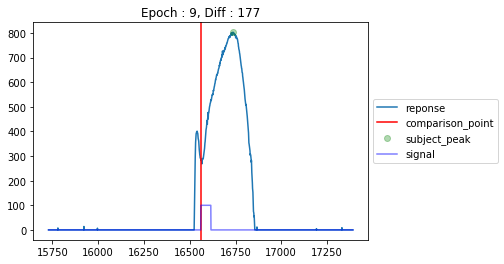

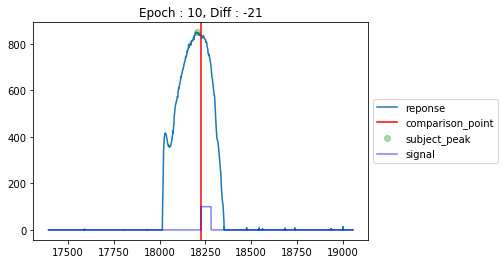

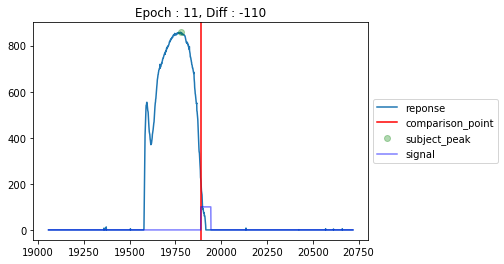

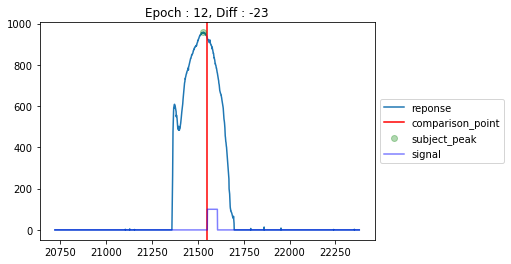

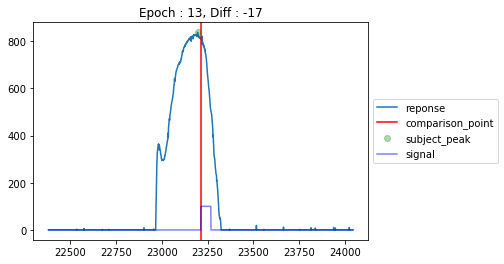

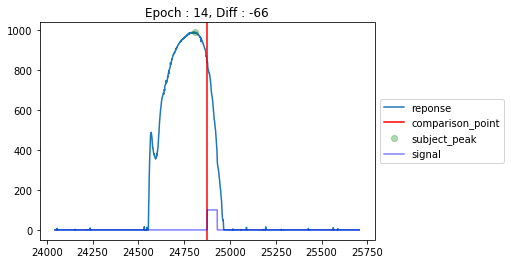

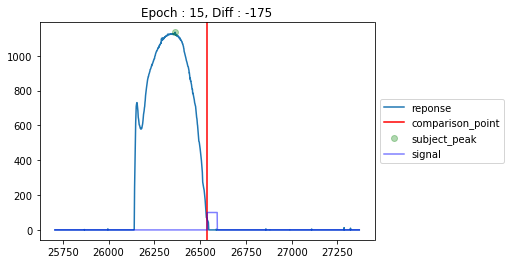

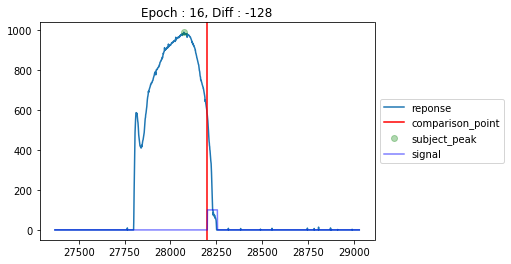

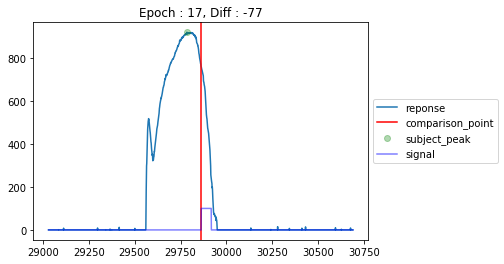

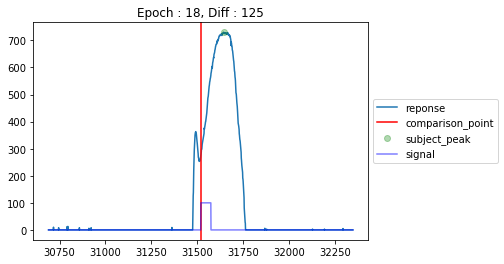

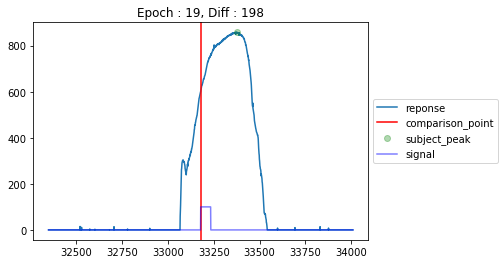

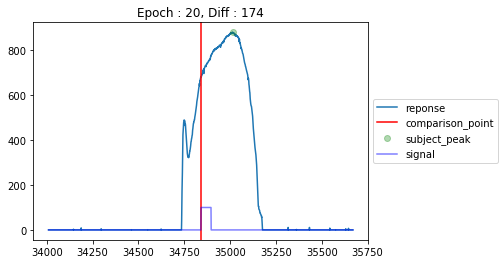

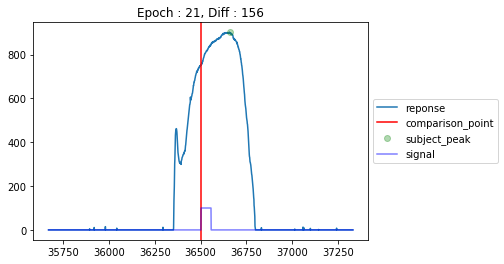

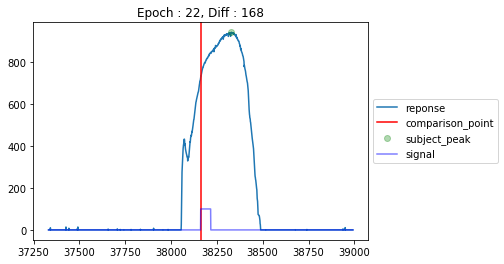

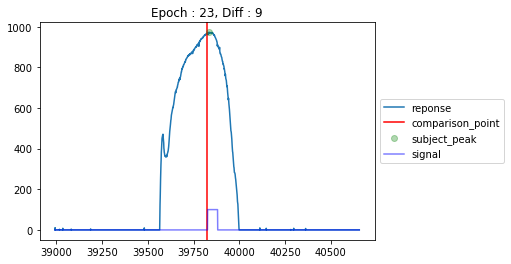

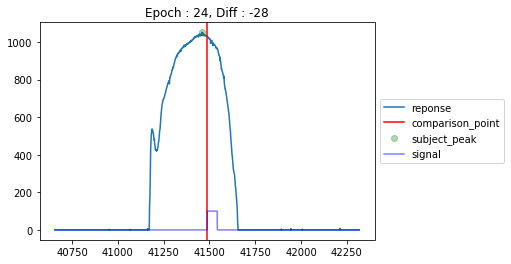

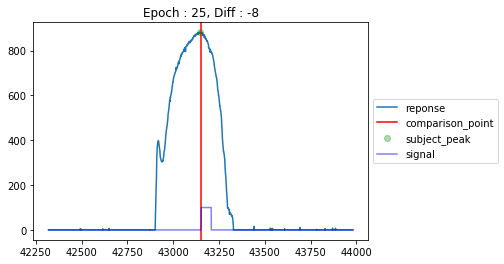

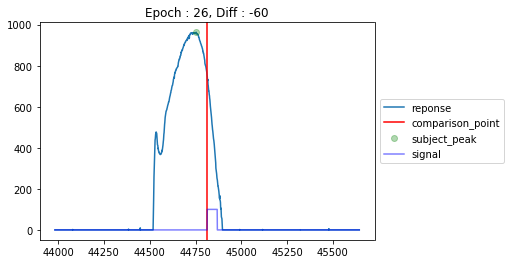

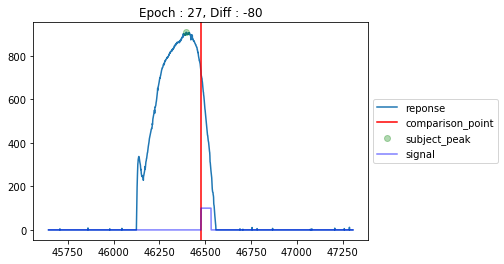

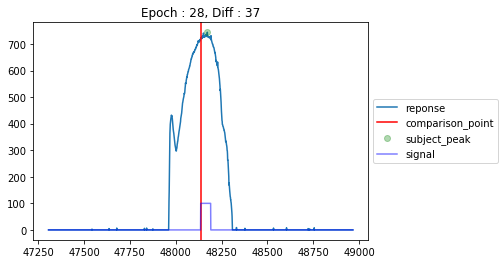

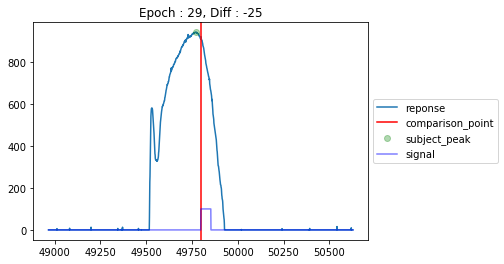

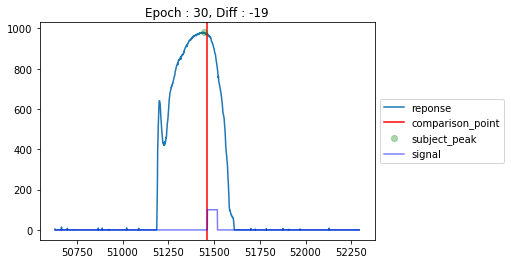

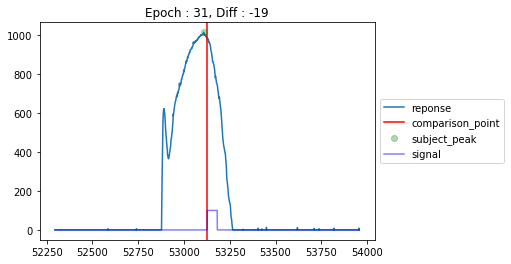

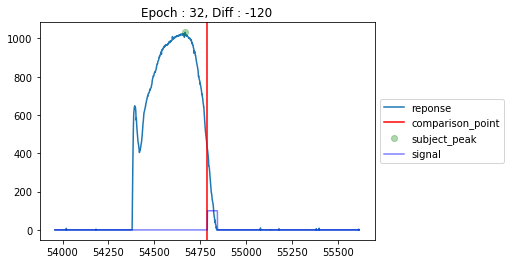

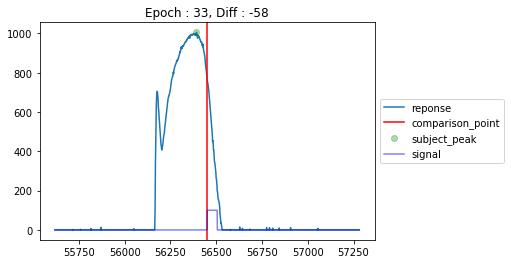

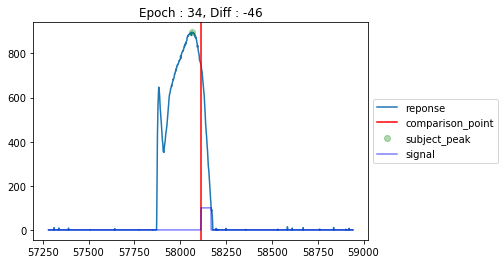

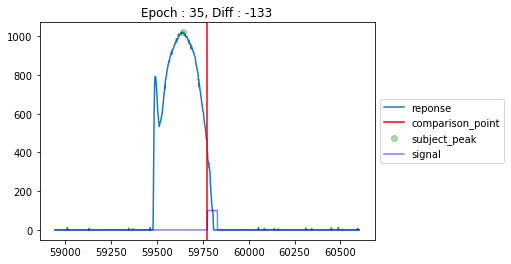

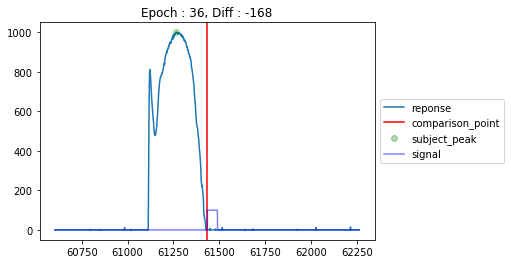

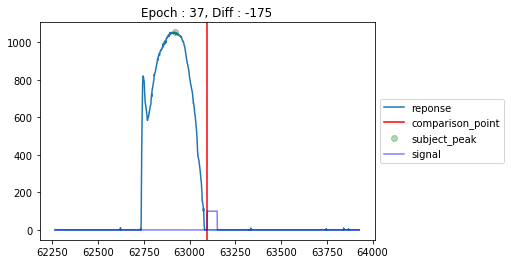

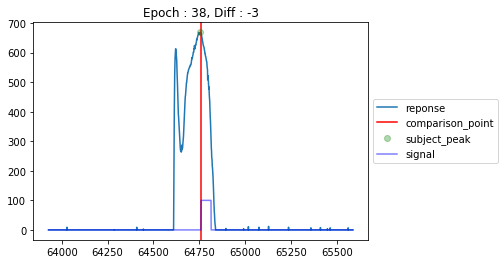

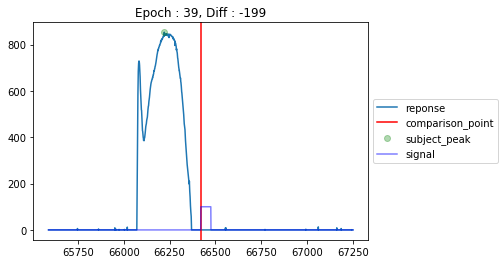

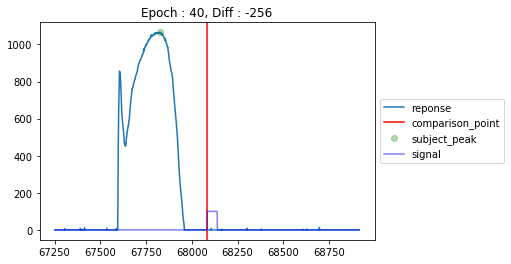

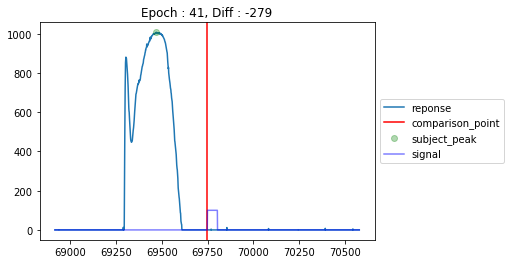

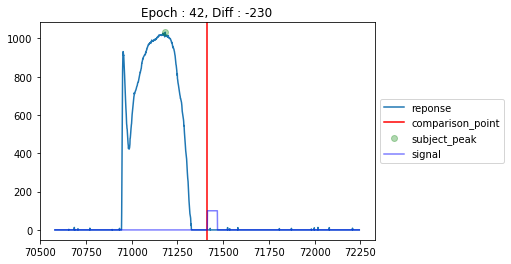

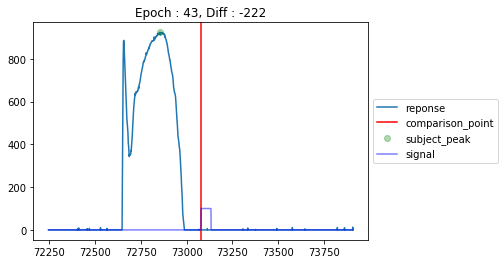

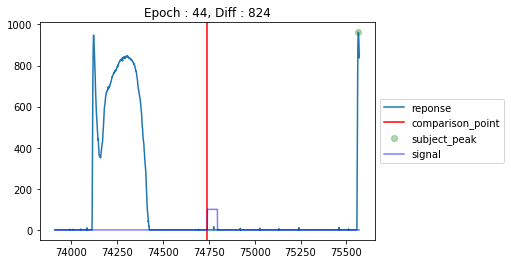

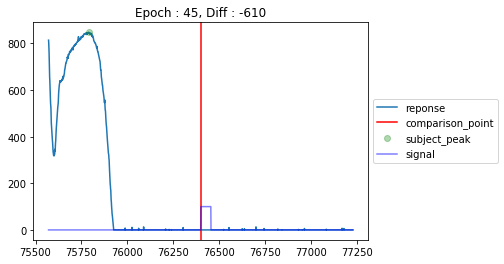

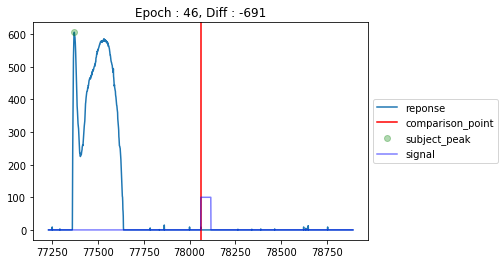

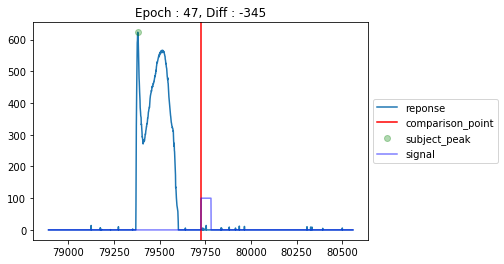

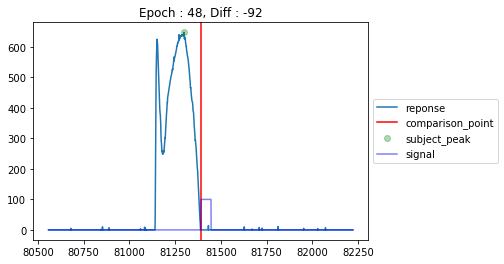

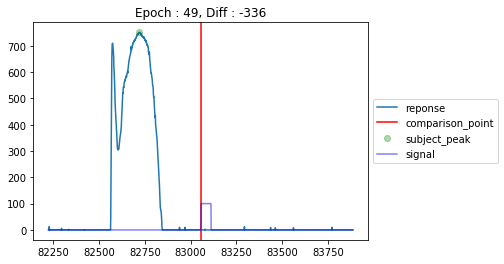

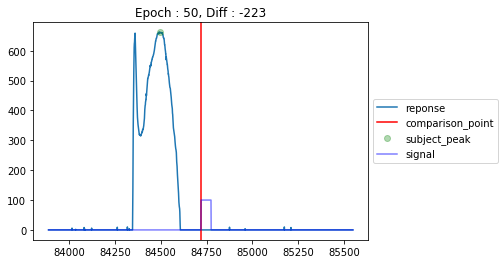

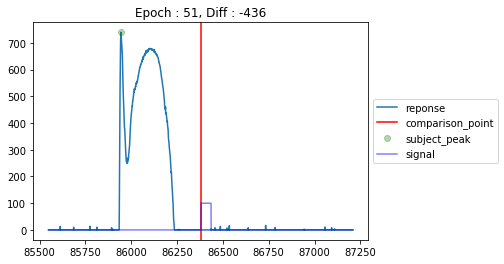

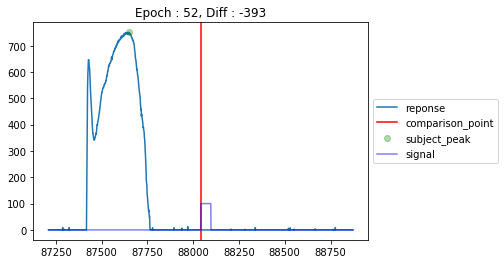

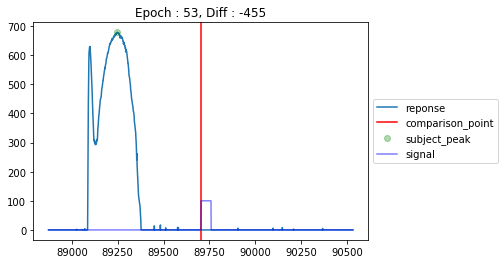

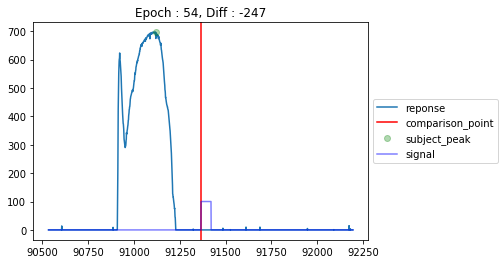

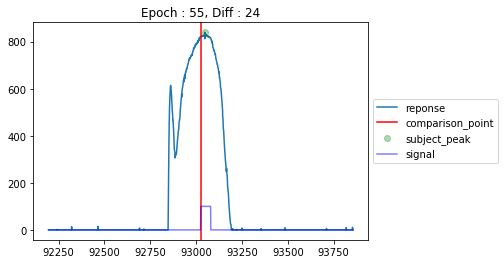

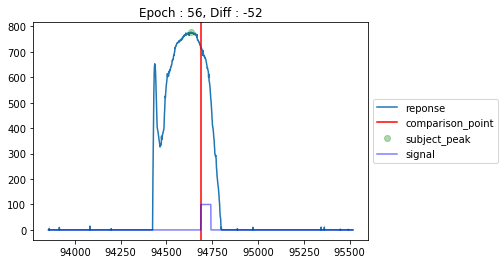

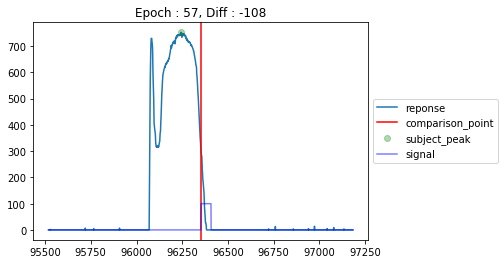

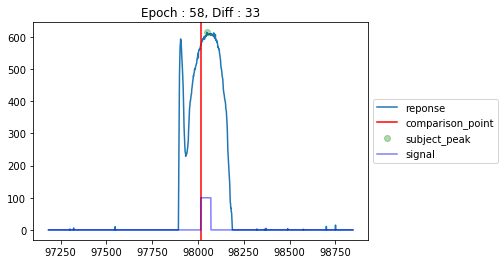

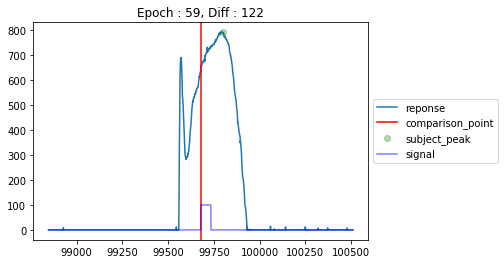

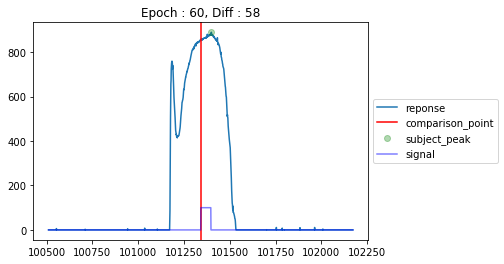

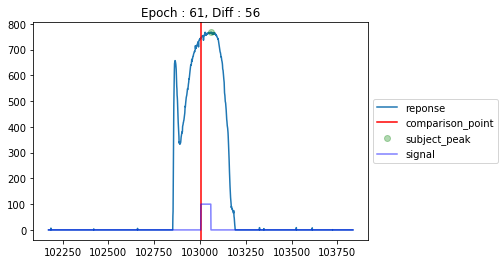

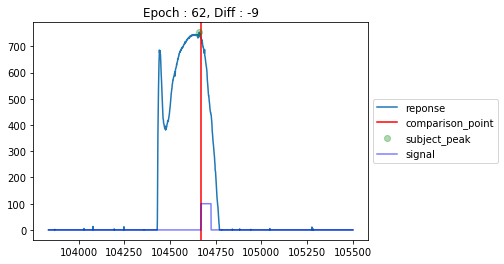

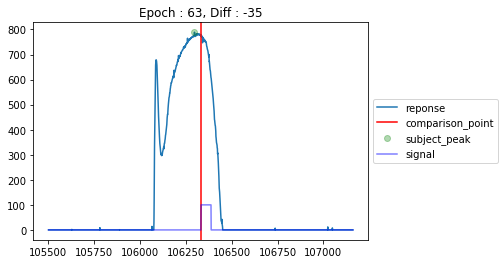

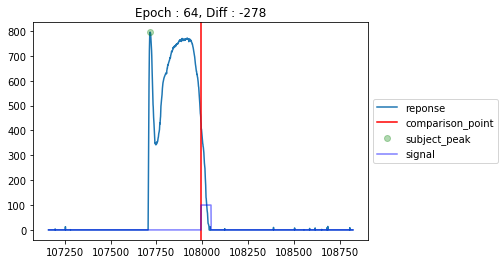

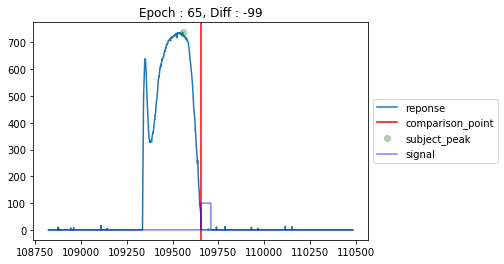

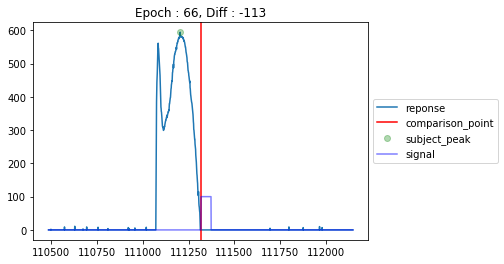

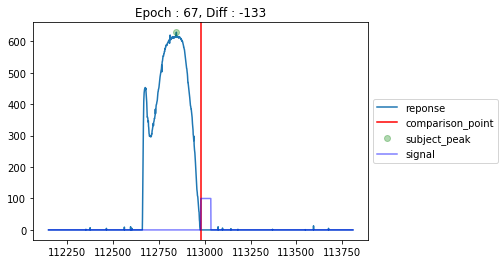

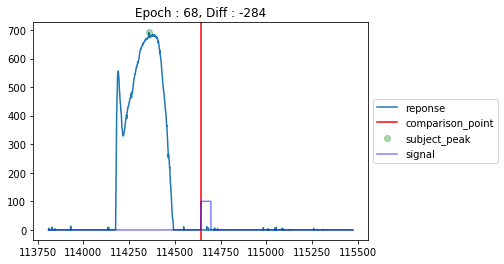

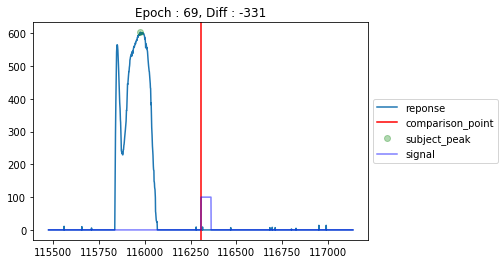

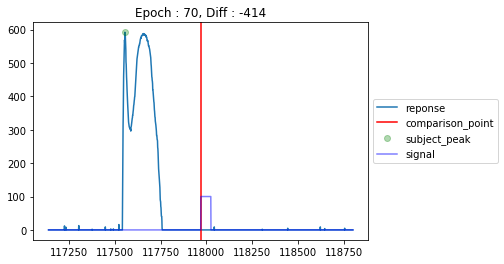

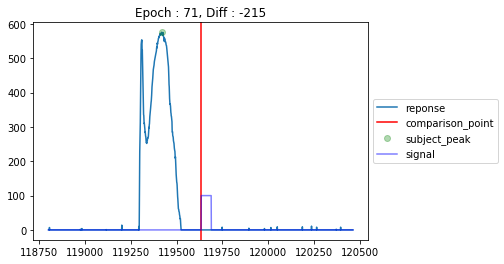

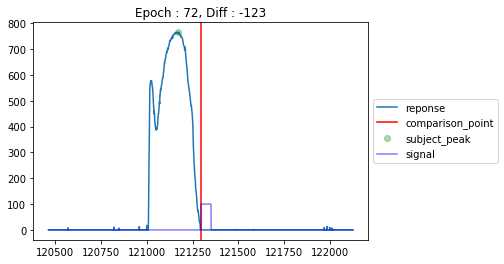

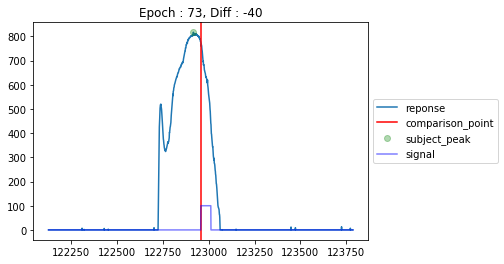

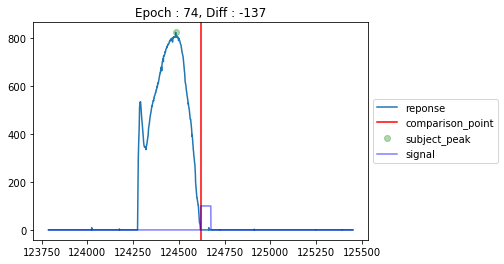

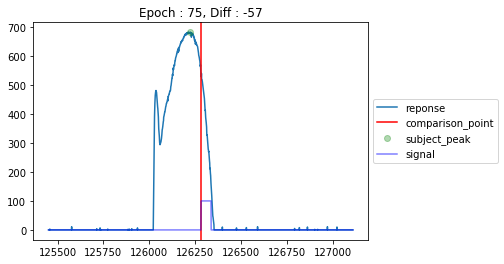

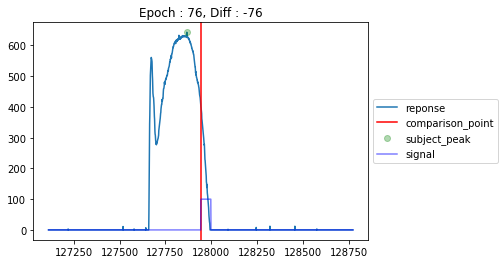

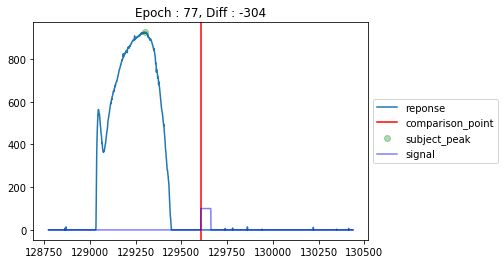

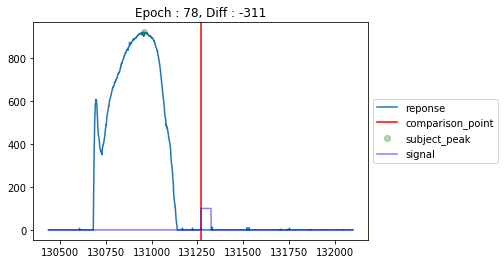

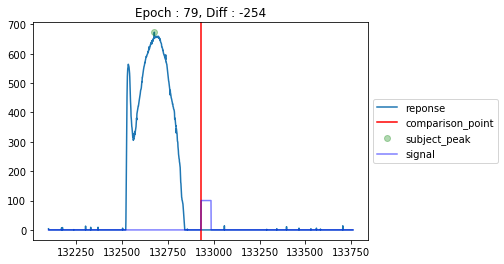

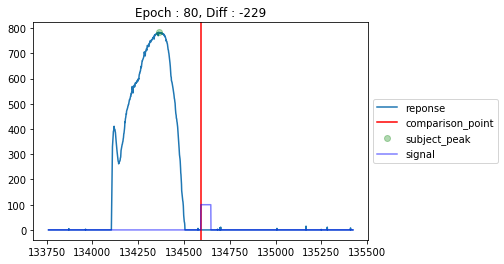

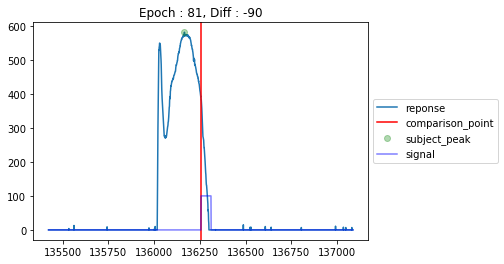

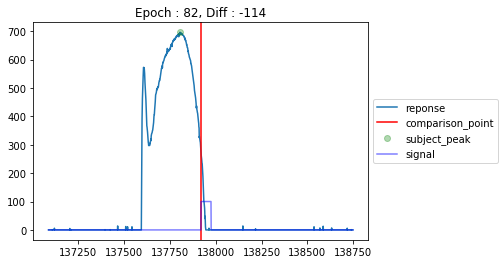

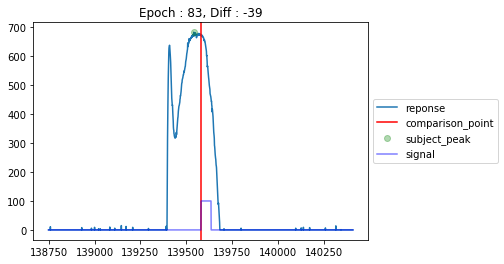

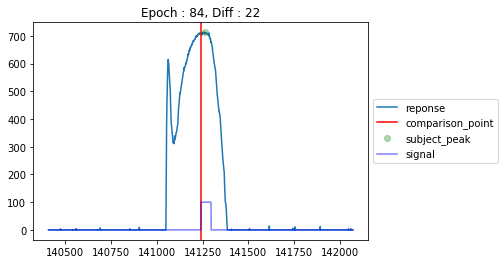

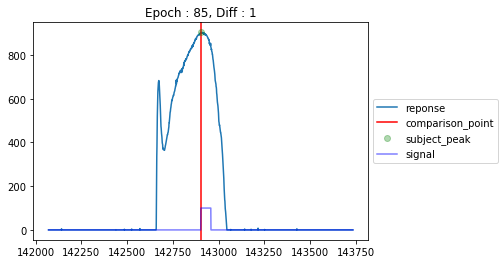

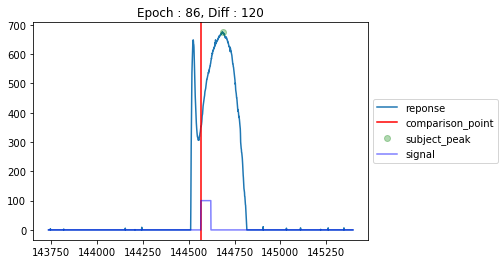

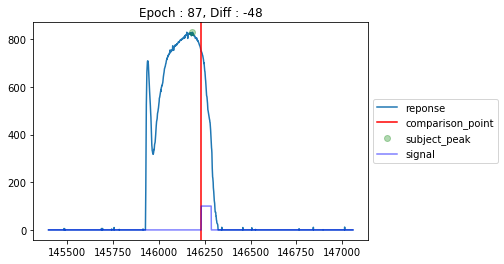

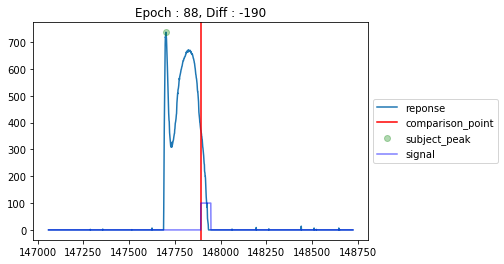

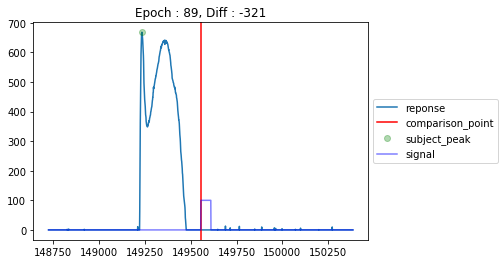

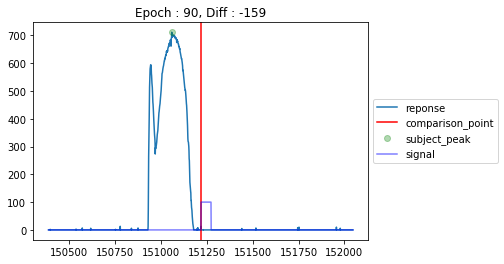

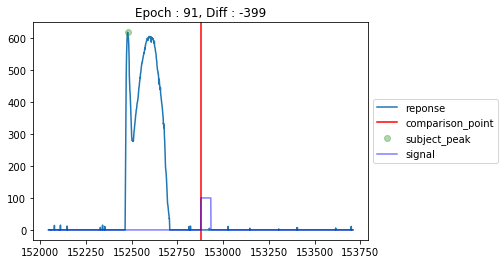

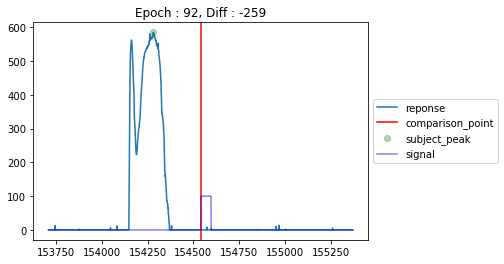

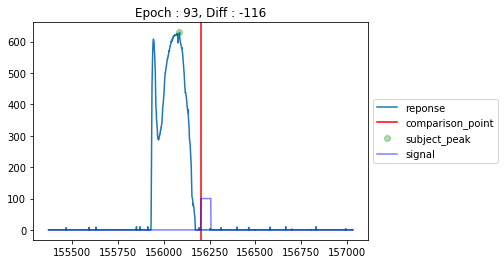

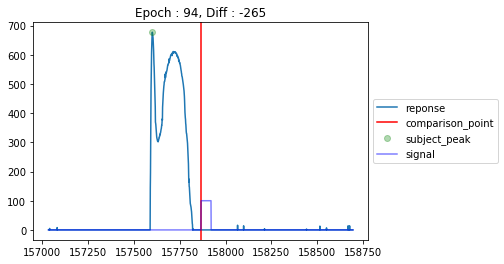

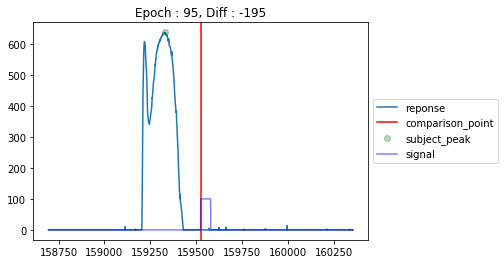

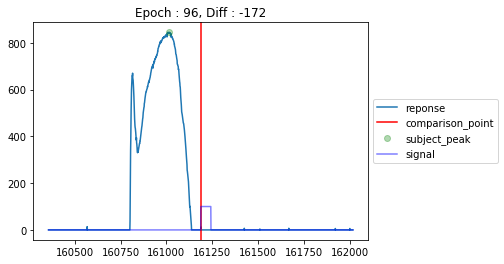

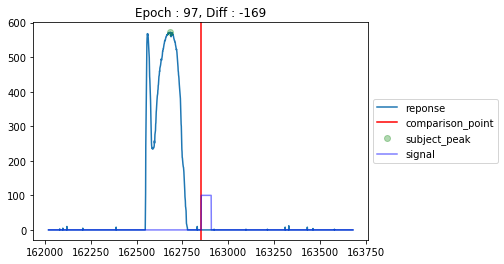

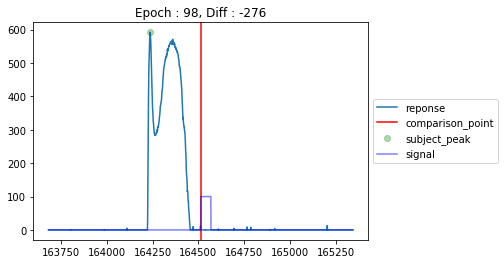

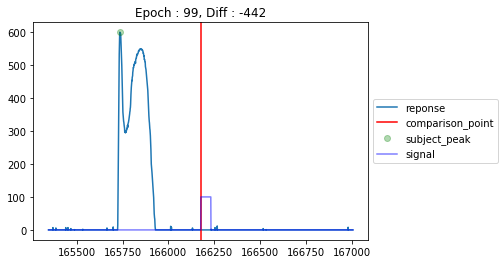

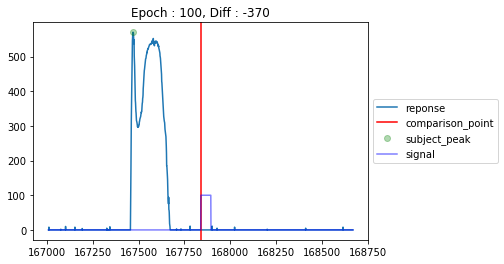

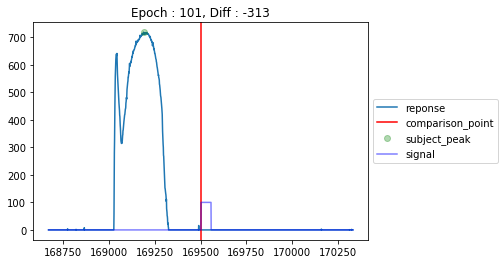

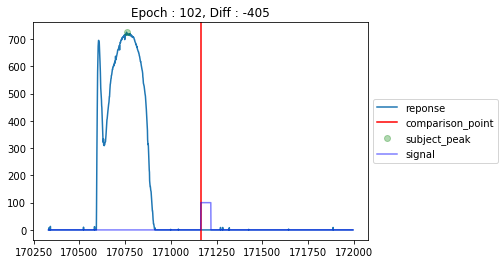

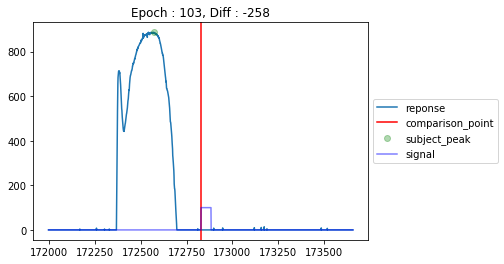

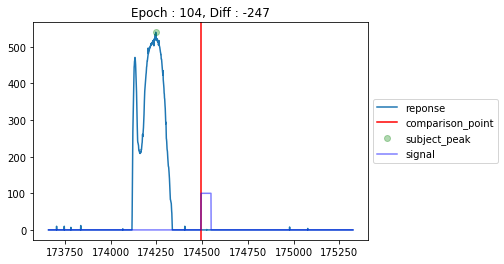

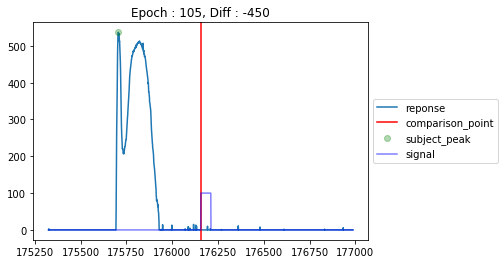

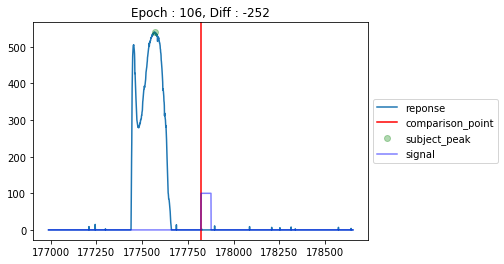

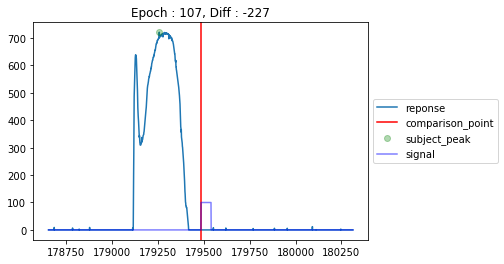

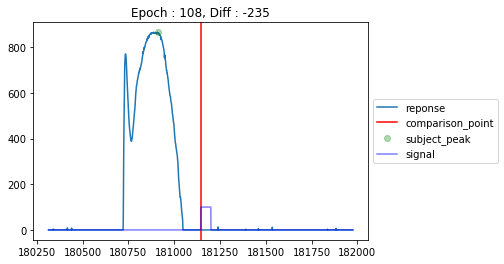

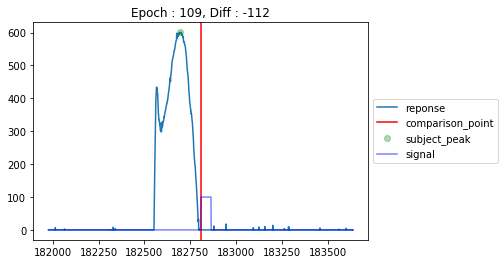

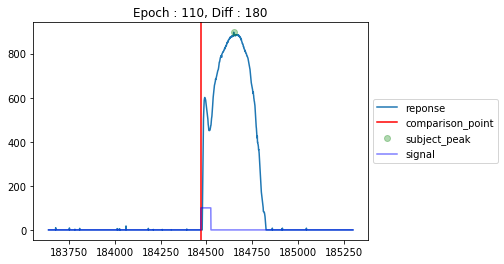

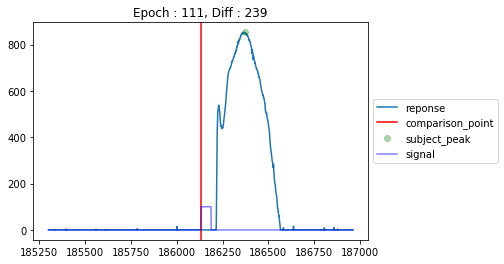

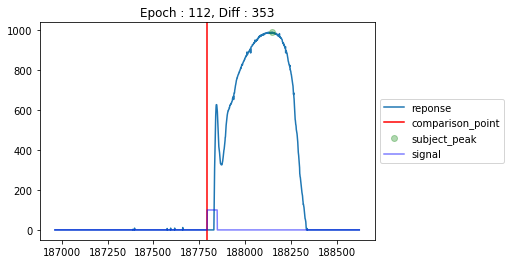

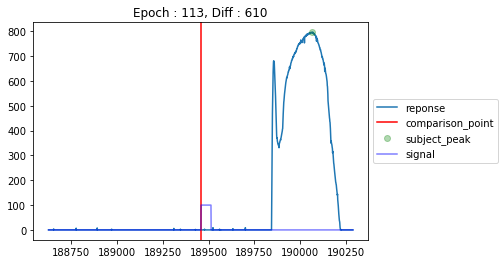

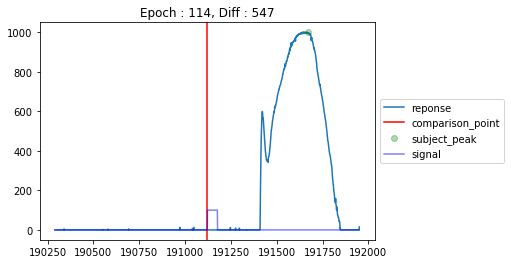

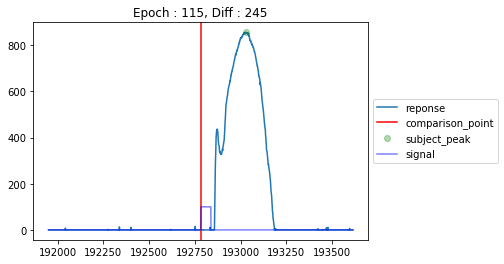

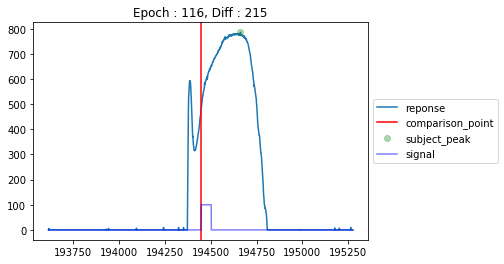

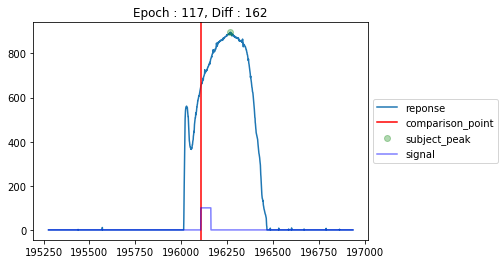

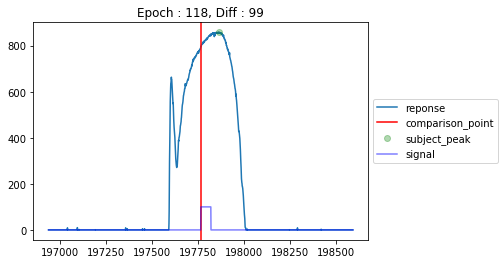

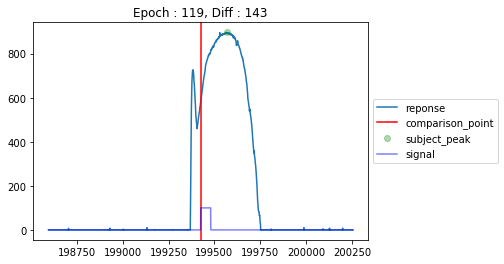

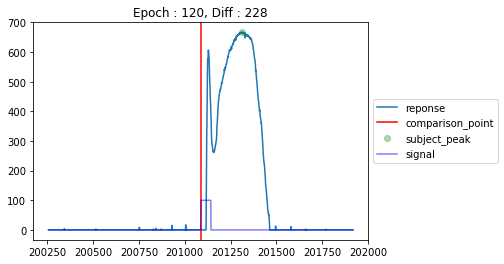

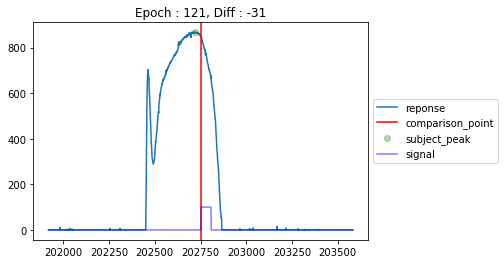

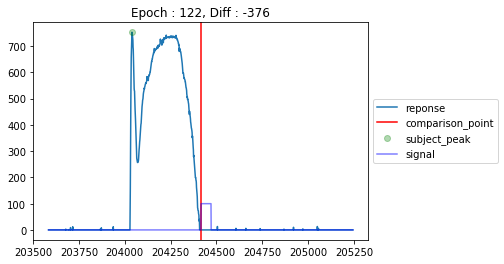

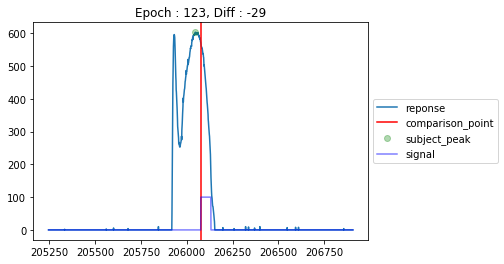

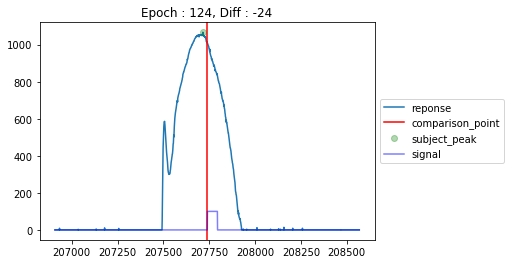

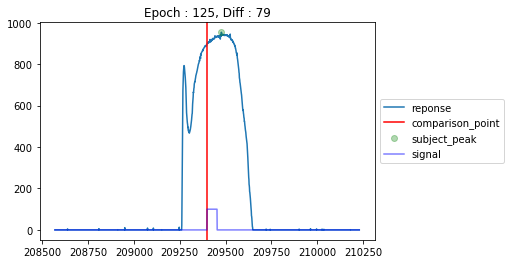

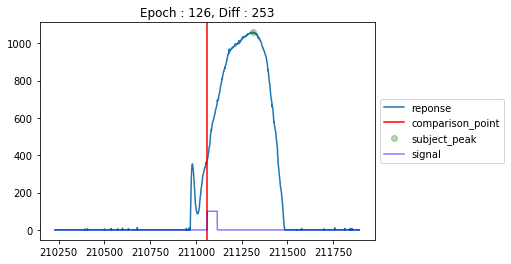

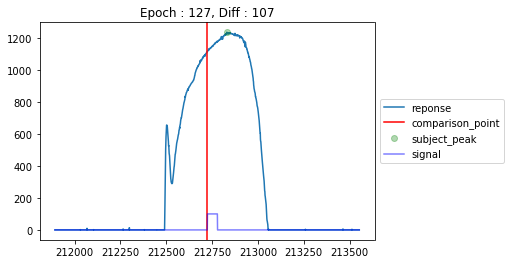

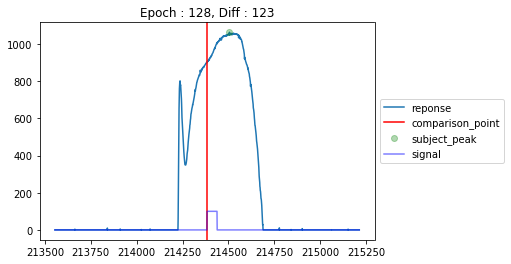

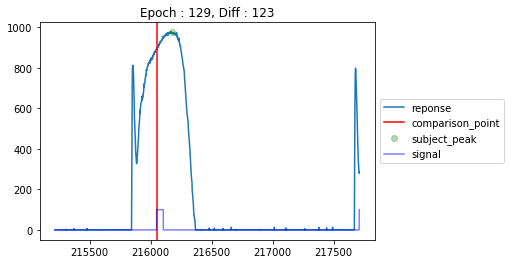

In [256]:
df = pd.DataFrame()
for num, (subject_response_df, onset_marker, signal) in enumerate(zip(subject_response_data,
                                                                      onset_index,
                                                                      signal_data)):
    peak_index = indexes(subject_response_df, 
                         thres=0.999, 
                         min_dist=len(subject_response_df))
#     peak_diff = subject_response_df.index[peak_index].values - onset_marker 
    
    tmp = pd.DataFrame({'epoch':[num],
                        'response_peak_index':peak_index,
                        'response_peak_time':subject_response_df.index[peak_index].values,
                        'response_peak_value':subject_response_df.values[peak_index],
                        'signal_peak_time':onset_marker,
                       })
    tmp['response_diff_time'] = tmp['response_peak_time'] - tmp['signal_peak_time']
    df = pd.concat([df, tmp])
    

    plt.plot(subject_response_df, label='reponse')
    plt.axvline(x=onset_marker, color='r', label='comparison_point')
    
    plt.plot(subject_response_df.index[peak_index].values, 
             subject_response_df.values[peak_index], 'go', alpha=0.3,
            label='subject_peak')

    plt.plot(signal*100, 'b', alpha=0.5, label='signal')
    plt.title('Epoch : {}, Diff : {}'.format(num, tmp['response_diff_time'].values[0]))
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.show()
    


In [257]:
df

epoch  response_peak_index  response_peak_time  response_peak_value  \
0       0                  566                 566                 13.0   
0       1                  746                3181                769.0   
0       2                  889                4987                897.0   
0       3                  950                6711                920.0   
0       4                  852                8276               1132.0   
0       5                  938               10023                758.0   
0       6                  796               11540                933.0   
0       7                  823               13228                692.0   
0       8                  848               14914                773.0   
0       9                 1008               16737                803.0   
0      10                  812               18204                850.0   
0      11                  721               19778                858.0   
0      12                  808               21528                958.0   
0      13                  814               23195                838.0   
0      14                  765               24809                989.0   
0      15                  656               26363               1135.0   
0      16                  703               28073                988.0   
0      17                  754               29785                920.0   
0      18                  954               31644                730.0   
0      19                 1027               33376                858.0   
0      20                 1005               35015                881.0   
0      21                  987               36658                902.0   
0      22                  997               38329                943.0   
0      23                  842               39835                973.0   
0      24                  803               41459               1052.0   
0      25                  825               43144                882.0   
0      26                  771               44753                963.0   
0      27                  751               46396                908.0   
0      28                  866               48172                744.0   
0      29                  806               49773                942.0   
..    ...                  ...                 ...                  ...   
0     100                  461              167469                570.0   
0     101                  518              169189                718.0   
0     102                  426              170758                725.0   
0     103                  575              172570                887.0   
0     104                  586              174246                540.0   
0     105                  381              175706                537.0   
0     106                  581              177569                540.0   
0     107                  604              179257                721.0   
0     108                  596              180910                865.0   
0     109                  719              182696                601.0   
0     110                 1011              184649                897.0   
0     111                 1070              186371                853.0   
0     112                 1184              188146                991.0   
0     113                 1443              190068                796.0   
0     114                 1378              191668               1000.0   
0     115                 1076              193027                856.0   
0     116                 1048              194662                786.0   
0     117                  991              196268                896.0   
0     118                  928              197864                858.0   
0     119                  972              199567                897.0   
0     120                 1059              201315                667.0   
0     121                  80

In [261]:
df.to_csv('~/Downloads/temporal_recalibration_raw.csv')

In [260]:
df.describe().to_csv('~/Downloads/temporal_recalibration_info.csv')

# Ignore below

> Difference between the time onset and the peak

In [75]:
subject_diff = data['time[us]'].loc[peak_indexes].values - data['time[us]'].loc[high_peak_indexes].values

In [77]:
print('Mean of the difference : {}'.format(subject_diff.mean()))
print('Std of the difference : {}'.format(subject_diff.std()))

Mean of the difference : 565772.9769230769
Std of the difference : 77951.7547707422
